<a href="https://colab.research.google.com/github/pavankum/colab-fold-files/blob/main/ECDs_w_TM_Apo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.5: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5).

Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/AlphaFold2.ipynb), [v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

In [1]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'LSPGLKCVCLLCDSSNFTCQTEGACWASVMLTNGKEQVIKSCVSLPELNAQVFCHSSNNVTKTECCFTDFCNNITLHLPTASPNAPKLGPMELAIIITVPVCLLSIAAMLTVW:LSPGLKCVCLLCDSSNFTCQTEGACWASVMLTNGKEQVIKSCVSLPELNAQVFCHSSNNVTKTECCFTDFCNNITLHLPTASPNAPKLGPMELAIIITVPVCLLSIAAMLTVW:SGRGEAETRECIYYNANWELERTNQSGLERCEGEQDKRLHCYASWRNSSGTIELVKKGCWLDDFNCYDRQECVATEENPQVYFCCCEGNFCNERFTHLPEAGGPEVTYEPPPTAPTLLTVLAYSLLPIGGLSLIVLLAFW:SGRGEAETRECIYYNANWELERTNQSGLERCEGEQDKRLHCYASWRNSSGTIELVKKGCWLDDFNCYDRQECVATEENPQVYFCCCEGNFCNERFTHLPEAGGPEVTYEPPPTAPTLLTVLAYSLLPIGGLSLIVLLAFW' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'tetramer_w_ECD_and_TM_Apo' #@param {type:"string"}
# number of models to use
num_relax = 1 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "pdb100" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname tetramer_w_ECD_and_TM_Apo_84146
sequence LSPGLKCVCLLCDSSNFTCQTEGACWASVMLTNGKEQVIKSCVSLPELNAQVFCHSSNNVTKTECCFTDFCNNITLHLPTASPNAPKLGPMELAIIITVPVCLLSIAAMLTVW:LSPGLKCVCLLCDSSNFTCQTEGACWASVMLTNGKEQVIKSCVSLPELNAQVFCHSSNNVTKTECCFTDFCNNITLHLPTASPNAPKLGPMELAIIITVPVCLLSIAAMLTVW:SGRGEAETRECIYYNANWELERTNQSGLERCEGEQDKRLHCYASWRNSSGTIELVKKGCWLDDFNCYDRQECVATEENPQVYFCCCEGNFCNERFTHLPEAGGPEVTYEPPPTAPTLLTVLAYSLLPIGGLSLIVLLAFW:SGRGEAETRECIYYNANWELERTNQSGLERCEGEQDKRLHCYASWRNSSGTIELVKKGCWLDDFNCYDRQECVATEENPQVYFCCCEGNFCNERFTHLPEAGGPEVTYEPPPTAPTLLTVLAYSLLPIGGLSLIVLLAFW
length 506


In [2]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
installing conda...
installing hhsuite and amber...
CPU times: user 297 ms, sys: 44.3 ms, total: 342 ms
Wall time: 1min 32s


In [3]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [4]:
#@markdown ### Advanced settings
model_type = "alphafold2_multimer_v3" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "auto" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 2000 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.


#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 8 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = True #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = True #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

You are logged into Google Drive and are good to go!


2024-11-13 21:07:29,558 Running on GPU
2024-11-13 21:07:29,890 Found 9 citations for tools or databases
2024-11-13 21:07:29,890 Query 1/1: tetramer_w_ECD_and_TM_Apo_84146 (length 506)


PENDING:   0%|          | 0/300 [elapsed: 00:00 remaining: ?]

2024-11-13 21:07:30,450 Sleeping for 6s. Reason: PENDING


RUNNING:   2%|▏         | 6/300 [elapsed: 00:07 remaining: 05:48]

2024-11-13 21:07:37,001 Sleeping for 7s. Reason: RUNNING


RUNNING:   4%|▍         | 13/300 [elapsed: 00:14 remaining: 05:20]

2024-11-13 21:07:44,540 Sleeping for 9s. Reason: RUNNING


RUNNING:   7%|▋         | 22/300 [elapsed: 00:24 remaining: 05:02]

2024-11-13 21:07:54,078 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:33 remaining: 00:00]


2024-11-13 21:08:13,536 Sequence 0 found templates: ['7oly_K', '7mrz_C', '2l5s_A', '6mac_K', '2pjy_C', '3kfd_L', '2qjb_D', '3kfd_K', '2qj9_D', '2qja_D', '2k3g_A', '2qjb_C', '2qja_C', '1rew_D', '2qj9_C', '2h62_C', '1es7_B', '3evs_C', '7yru_A', '1cxo_A']
2024-11-13 21:08:17,734 Sequence 1 found templates: ['7mrz_C', '2goo_C', '7u5p_A', '1s4y_A', '1bte_A', '1nys_A', '1nyu_A', '1nyu_C', '7l0j_B', '7ppc_L', '7u5o_F', '7ppc_J', '2hlq_A', '2hlr_A', '7u5o_E', '7ppa_D', '7ppb_B', '7ppa_C', '7ppc_I', '7u5o_G']


PENDING:   0%|          | 0/300 [elapsed: 00:00 remaining: ?]

2024-11-13 21:08:18,272 Sleeping for 8s. Reason: PENDING


RUNNING:   3%|▎         | 8/300 [elapsed: 00:09 remaining: 05:30]

2024-11-13 21:08:26,789 Sleeping for 9s. Reason: RUNNING


RUNNING:   6%|▌         | 17/300 [elapsed: 00:18 remaining: 05:07]

2024-11-13 21:08:36,339 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:24 remaining: 00:00]


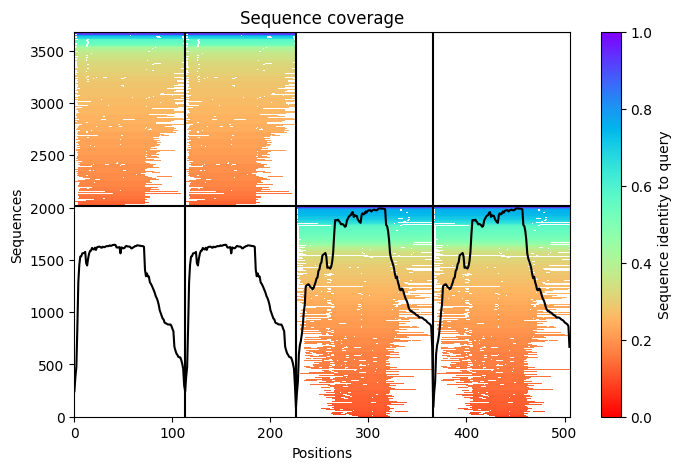

2024-11-13 21:08:43,612 Setting max_seq=508, max_extra_seq=2048
2024-11-13 21:10:19,408 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=56.9 pTM=0.278 ipTM=0.118
2024-11-13 21:10:32,530 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=57.4 pTM=0.285 ipTM=0.123 tol=7.98
2024-11-13 21:10:45,717 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=58.2 pTM=0.291 ipTM=0.129 tol=5.65
2024-11-13 21:10:59,061 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=57.6 pTM=0.288 ipTM=0.129 tol=3.39
2024-11-13 21:11:12,511 alphafold2_multimer_v3_model_1_seed_000 recycle=4 pLDDT=57.2 pTM=0.294 ipTM=0.135 tol=6.16
2024-11-13 21:11:26,079 alphafold2_multimer_v3_model_1_seed_000 recycle=5 pLDDT=58.2 pTM=0.29 ipTM=0.132 tol=3.12
2024-11-13 21:11:39,675 alphafold2_multimer_v3_model_1_seed_000 recycle=6 pLDDT=57.8 pTM=0.296 ipTM=0.14 tol=2.6
2024-11-13 21:11:53,172 alphafold2_multimer_v3_model_1_seed_000 recycle=7 pLDDT=58.4 pTM=0.297 ipTM=0.14 tol=2.83
2024-11-13 21:12:06,618 alpha

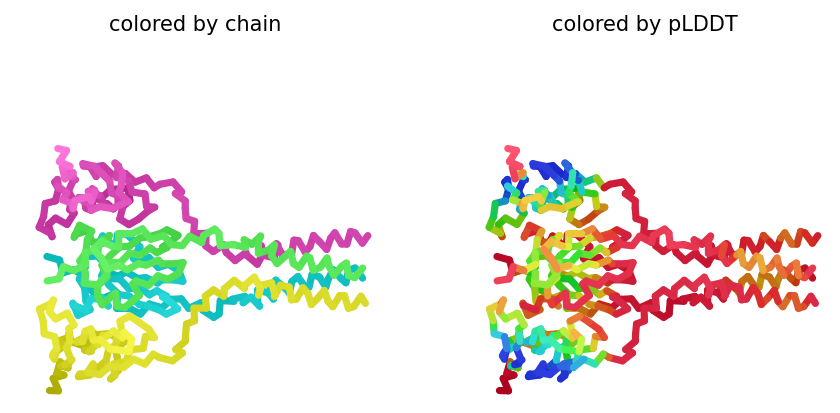

2024-11-13 21:15:01,227 alphafold2_multimer_v3_model_2_seed_000 recycle=0 pLDDT=59.4 pTM=0.284 ipTM=0.123
2024-11-13 21:15:14,622 alphafold2_multimer_v3_model_2_seed_000 recycle=1 pLDDT=61 pTM=0.296 ipTM=0.141 tol=8.41
2024-11-13 21:15:27,985 alphafold2_multimer_v3_model_2_seed_000 recycle=2 pLDDT=70.6 pTM=0.434 ipTM=0.352 tol=5.89
2024-11-13 21:15:41,330 alphafold2_multimer_v3_model_2_seed_000 recycle=3 pLDDT=68 pTM=0.411 ipTM=0.309 tol=10.8
2024-11-13 21:15:54,660 alphafold2_multimer_v3_model_2_seed_000 recycle=4 pLDDT=68.1 pTM=0.409 ipTM=0.302 tol=1.68
2024-11-13 21:16:07,992 alphafold2_multimer_v3_model_2_seed_000 recycle=5 pLDDT=67.2 pTM=0.393 ipTM=0.282 tol=0.61
2024-11-13 21:16:21,328 alphafold2_multimer_v3_model_2_seed_000 recycle=6 pLDDT=68.4 pTM=0.418 ipTM=0.313 tol=0.953
2024-11-13 21:16:34,666 alphafold2_multimer_v3_model_2_seed_000 recycle=7 pLDDT=68.3 pTM=0.409 ipTM=0.297 tol=0.638
2024-11-13 21:16:48,008 alphafold2_multimer_v3_model_2_seed_000 recycle=8 pLDDT=68 pTM=0.41

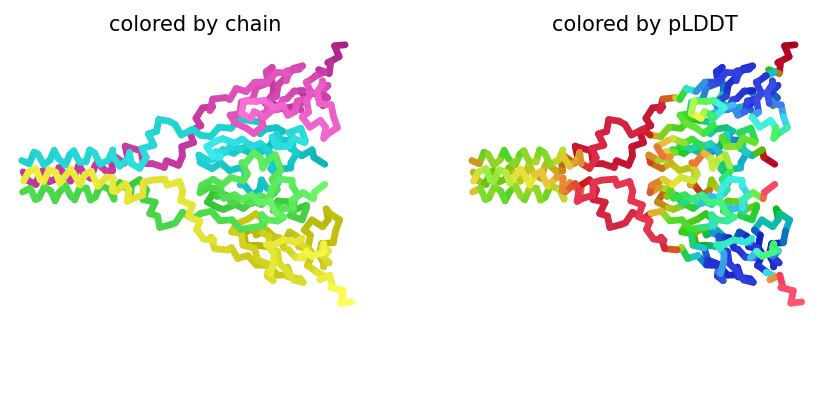

2024-11-13 21:17:42,077 alphafold2_multimer_v3_model_3_seed_000 recycle=0 pLDDT=58.3 pTM=0.274 ipTM=0.113
2024-11-13 21:17:55,466 alphafold2_multimer_v3_model_3_seed_000 recycle=1 pLDDT=56.4 pTM=0.277 ipTM=0.115 tol=12
2024-11-13 21:18:08,877 alphafold2_multimer_v3_model_3_seed_000 recycle=2 pLDDT=58.4 pTM=0.273 ipTM=0.107 tol=7.29
2024-11-13 21:18:22,281 alphafold2_multimer_v3_model_3_seed_000 recycle=3 pLDDT=57.4 pTM=0.268 ipTM=0.109 tol=11.8
2024-11-13 21:18:35,652 alphafold2_multimer_v3_model_3_seed_000 recycle=4 pLDDT=58.1 pTM=0.274 ipTM=0.109 tol=6.43
2024-11-13 21:18:49,156 alphafold2_multimer_v3_model_3_seed_000 recycle=5 pLDDT=54.8 pTM=0.271 ipTM=0.105 tol=11.3
2024-11-13 21:19:02,559 alphafold2_multimer_v3_model_3_seed_000 recycle=6 pLDDT=57.5 pTM=0.268 ipTM=0.106 tol=7.05
2024-11-13 21:19:16,065 alphafold2_multimer_v3_model_3_seed_000 recycle=7 pLDDT=58.6 pTM=0.271 ipTM=0.105 tol=4.69
2024-11-13 21:19:29,556 alphafold2_multimer_v3_model_3_seed_000 recycle=8 pLDDT=58 pTM=0.27

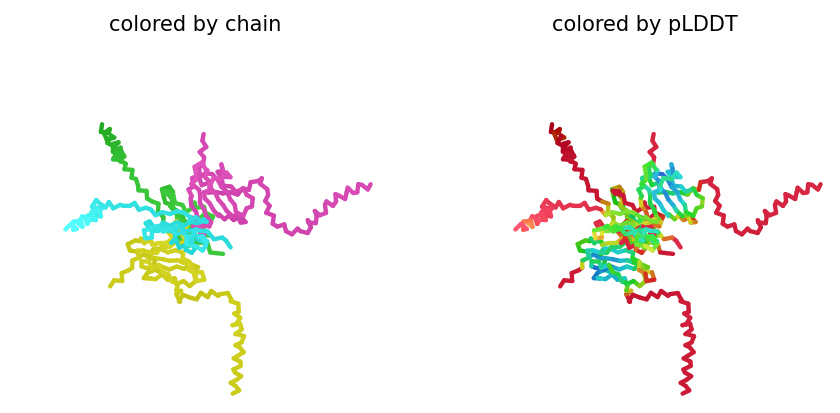

2024-11-13 21:22:24,624 alphafold2_multimer_v3_model_4_seed_000 recycle=0 pLDDT=60.1 pTM=0.287 ipTM=0.14
2024-11-13 21:22:38,012 alphafold2_multimer_v3_model_4_seed_000 recycle=1 pLDDT=58.7 pTM=0.288 ipTM=0.129 tol=5.14
2024-11-13 21:22:51,393 alphafold2_multimer_v3_model_4_seed_000 recycle=2 pLDDT=57.9 pTM=0.298 ipTM=0.143 tol=8.23
2024-11-13 21:23:04,768 alphafold2_multimer_v3_model_4_seed_000 recycle=3 pLDDT=61.1 pTM=0.32 ipTM=0.166 tol=12
2024-11-13 21:23:18,136 alphafold2_multimer_v3_model_4_seed_000 recycle=4 pLDDT=59.1 pTM=0.306 ipTM=0.148 tol=2.88
2024-11-13 21:23:31,531 alphafold2_multimer_v3_model_4_seed_000 recycle=5 pLDDT=59 pTM=0.298 ipTM=0.136 tol=4.53
2024-11-13 21:23:44,917 alphafold2_multimer_v3_model_4_seed_000 recycle=6 pLDDT=59.6 pTM=0.31 ipTM=0.154 tol=3.12
2024-11-13 21:23:58,316 alphafold2_multimer_v3_model_4_seed_000 recycle=7 pLDDT=59.5 pTM=0.303 ipTM=0.145 tol=1.6
2024-11-13 21:24:11,709 alphafold2_multimer_v3_model_4_seed_000 recycle=8 pLDDT=59.1 pTM=0.307 ip

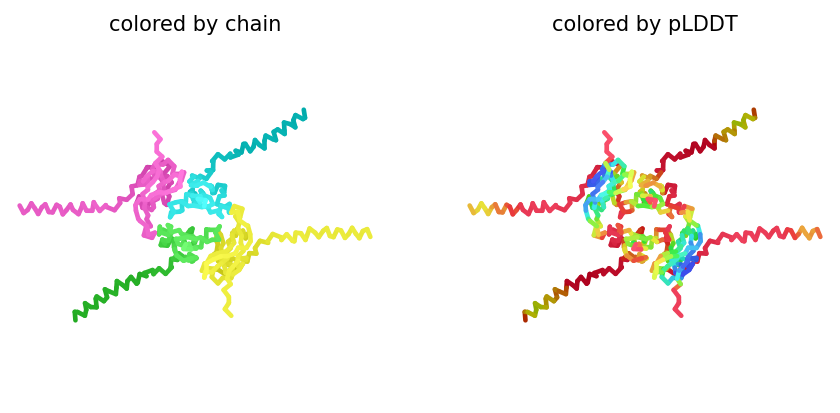

2024-11-13 21:27:06,383 alphafold2_multimer_v3_model_5_seed_000 recycle=0 pLDDT=58.8 pTM=0.275 ipTM=0.12
2024-11-13 21:27:19,771 alphafold2_multimer_v3_model_5_seed_000 recycle=1 pLDDT=56.3 pTM=0.277 ipTM=0.117 tol=4.59
2024-11-13 21:27:33,251 alphafold2_multimer_v3_model_5_seed_000 recycle=2 pLDDT=56.1 pTM=0.28 ipTM=0.115 tol=6.31
2024-11-13 21:27:46,718 alphafold2_multimer_v3_model_5_seed_000 recycle=3 pLDDT=55.7 pTM=0.287 ipTM=0.118 tol=14.6
2024-11-13 21:28:00,101 alphafold2_multimer_v3_model_5_seed_000 recycle=4 pLDDT=56.3 pTM=0.284 ipTM=0.119 tol=2.87
2024-11-13 21:28:13,510 alphafold2_multimer_v3_model_5_seed_000 recycle=5 pLDDT=56.6 pTM=0.28 ipTM=0.115 tol=4.61
2024-11-13 21:28:26,901 alphafold2_multimer_v3_model_5_seed_000 recycle=6 pLDDT=55.7 pTM=0.286 ipTM=0.123 tol=3.71
2024-11-13 21:28:40,288 alphafold2_multimer_v3_model_5_seed_000 recycle=7 pLDDT=56 pTM=0.288 ipTM=0.123 tol=2.95
2024-11-13 21:28:53,677 alphafold2_multimer_v3_model_5_seed_000 recycle=8 pLDDT=56 pTM=0.289 i

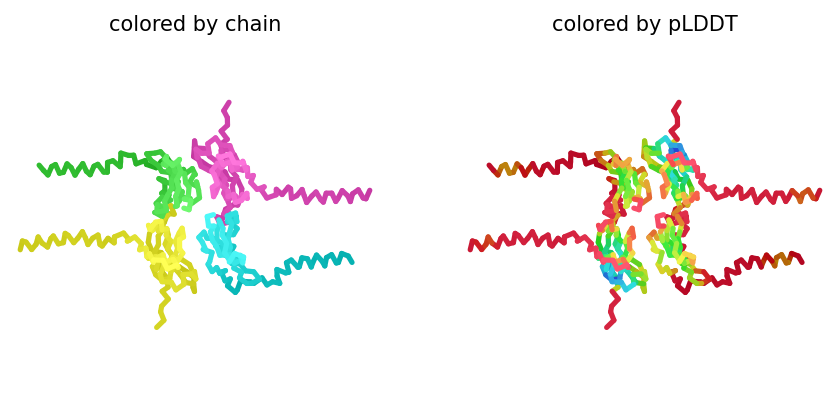

2024-11-13 21:31:48,353 alphafold2_multimer_v3_model_1_seed_001 recycle=0 pLDDT=58.8 pTM=0.291 ipTM=0.135
2024-11-13 21:32:01,726 alphafold2_multimer_v3_model_1_seed_001 recycle=1 pLDDT=59.1 pTM=0.304 ipTM=0.182 tol=7.82
2024-11-13 21:32:15,106 alphafold2_multimer_v3_model_1_seed_001 recycle=2 pLDDT=59.4 pTM=0.299 ipTM=0.146 tol=4.01
2024-11-13 21:32:28,516 alphafold2_multimer_v3_model_1_seed_001 recycle=3 pLDDT=59.4 pTM=0.292 ipTM=0.138 tol=2.57
2024-11-13 21:32:41,898 alphafold2_multimer_v3_model_1_seed_001 recycle=4 pLDDT=58.9 pTM=0.295 ipTM=0.139 tol=1.89
2024-11-13 21:32:55,279 alphafold2_multimer_v3_model_1_seed_001 recycle=5 pLDDT=59.5 pTM=0.297 ipTM=0.144 tol=4.16
2024-11-13 21:33:08,644 alphafold2_multimer_v3_model_1_seed_001 recycle=6 pLDDT=59.2 pTM=0.297 ipTM=0.139 tol=3.79
2024-11-13 21:33:22,031 alphafold2_multimer_v3_model_1_seed_001 recycle=7 pLDDT=59.7 pTM=0.29 ipTM=0.133 tol=4.35
2024-11-13 21:33:35,406 alphafold2_multimer_v3_model_1_seed_001 recycle=8 pLDDT=59.1 pTM=0

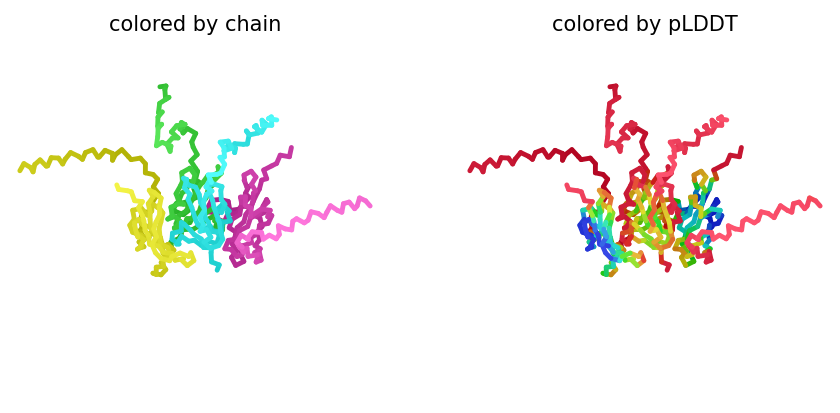

2024-11-13 21:36:30,228 alphafold2_multimer_v3_model_2_seed_001 recycle=0 pLDDT=59.8 pTM=0.284 ipTM=0.123
2024-11-13 21:36:43,580 alphafold2_multimer_v3_model_2_seed_001 recycle=1 pLDDT=62.4 pTM=0.298 ipTM=0.146 tol=11.6
2024-11-13 21:36:56,935 alphafold2_multimer_v3_model_2_seed_001 recycle=2 pLDDT=63.1 pTM=0.328 ipTM=0.194 tol=9.45
2024-11-13 21:37:10,275 alphafold2_multimer_v3_model_2_seed_001 recycle=3 pLDDT=67.8 pTM=0.419 ipTM=0.33 tol=3.77
2024-11-13 21:37:23,620 alphafold2_multimer_v3_model_2_seed_001 recycle=4 pLDDT=66.2 pTM=0.404 ipTM=0.299 tol=3.14
2024-11-13 21:37:36,976 alphafold2_multimer_v3_model_2_seed_001 recycle=5 pLDDT=66.6 pTM=0.389 ipTM=0.279 tol=2.06
2024-11-13 21:37:50,394 alphafold2_multimer_v3_model_2_seed_001 recycle=6 pLDDT=68.3 pTM=0.413 ipTM=0.316 tol=0.776
2024-11-13 21:38:03,812 alphafold2_multimer_v3_model_2_seed_001 recycle=7 pLDDT=68.8 pTM=0.413 ipTM=0.302 tol=0.718
2024-11-13 21:38:17,223 alphafold2_multimer_v3_model_2_seed_001 recycle=8 pLDDT=67.9 pTM

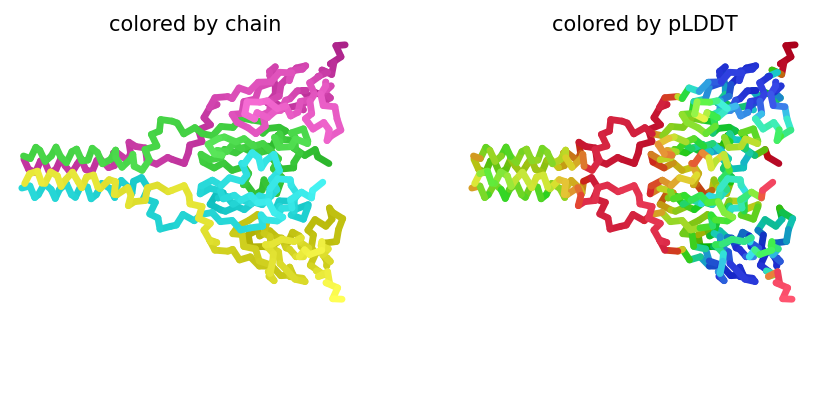

2024-11-13 21:38:58,506 alphafold2_multimer_v3_model_3_seed_001 recycle=0 pLDDT=58.2 pTM=0.281 ipTM=0.124
2024-11-13 21:39:11,967 alphafold2_multimer_v3_model_3_seed_001 recycle=1 pLDDT=61.7 pTM=0.331 ipTM=0.198 tol=12.6
2024-11-13 21:39:25,371 alphafold2_multimer_v3_model_3_seed_001 recycle=2 pLDDT=62.2 pTM=0.335 ipTM=0.192 tol=3.66
2024-11-13 21:39:38,753 alphafold2_multimer_v3_model_3_seed_001 recycle=3 pLDDT=61.4 pTM=0.331 ipTM=0.197 tol=2.64
2024-11-13 21:39:52,108 alphafold2_multimer_v3_model_3_seed_001 recycle=4 pLDDT=59.9 pTM=0.303 ipTM=0.152 tol=1.51
2024-11-13 21:40:05,466 alphafold2_multimer_v3_model_3_seed_001 recycle=5 pLDDT=59.1 pTM=0.294 ipTM=0.136 tol=4.7
2024-11-13 21:40:18,807 alphafold2_multimer_v3_model_3_seed_001 recycle=6 pLDDT=58.5 pTM=0.29 ipTM=0.132 tol=5.07
2024-11-13 21:40:32,162 alphafold2_multimer_v3_model_3_seed_001 recycle=7 pLDDT=58.8 pTM=0.289 ipTM=0.13 tol=5.01
2024-11-13 21:40:45,540 alphafold2_multimer_v3_model_3_seed_001 recycle=8 pLDDT=58.8 pTM=0.2

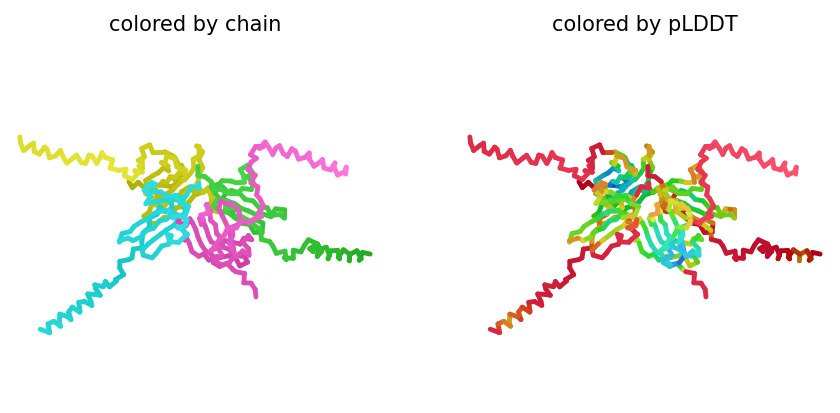

2024-11-13 21:43:40,716 alphafold2_multimer_v3_model_4_seed_001 recycle=0 pLDDT=60.7 pTM=0.299 ipTM=0.146
2024-11-13 21:43:54,163 alphafold2_multimer_v3_model_4_seed_001 recycle=1 pLDDT=59.5 pTM=0.296 ipTM=0.143 tol=8.19
2024-11-13 21:44:07,602 alphafold2_multimer_v3_model_4_seed_001 recycle=2 pLDDT=60.3 pTM=0.294 ipTM=0.139 tol=5.65
2024-11-13 21:44:21,057 alphafold2_multimer_v3_model_4_seed_001 recycle=3 pLDDT=59.3 pTM=0.3 ipTM=0.144 tol=4.28
2024-11-13 21:44:34,415 alphafold2_multimer_v3_model_4_seed_001 recycle=4 pLDDT=59.9 pTM=0.304 ipTM=0.151 tol=7.44
2024-11-13 21:44:47,790 alphafold2_multimer_v3_model_4_seed_001 recycle=5 pLDDT=61.4 pTM=0.308 ipTM=0.146 tol=8.06
2024-11-13 21:45:01,170 alphafold2_multimer_v3_model_4_seed_001 recycle=6 pLDDT=60.2 pTM=0.299 ipTM=0.142 tol=2.07
2024-11-13 21:45:14,632 alphafold2_multimer_v3_model_4_seed_001 recycle=7 pLDDT=60.2 pTM=0.304 ipTM=0.149 tol=5.17
2024-11-13 21:45:28,086 alphafold2_multimer_v3_model_4_seed_001 recycle=8 pLDDT=60.4 pTM=0.

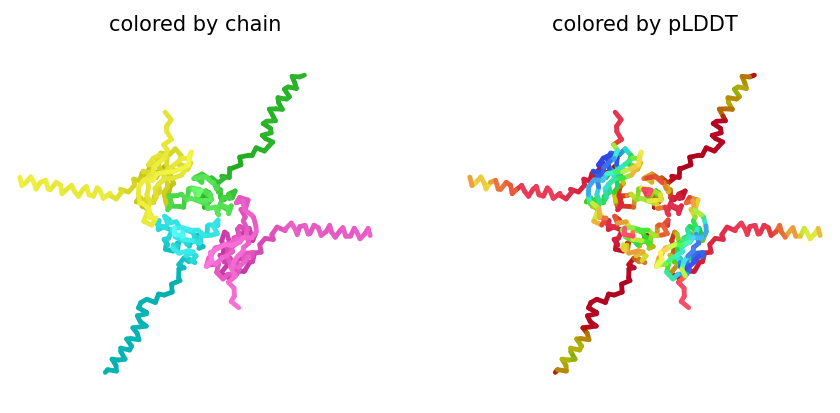

2024-11-13 21:48:22,668 alphafold2_multimer_v3_model_5_seed_001 recycle=0 pLDDT=57.9 pTM=0.282 ipTM=0.127
2024-11-13 21:48:36,053 alphafold2_multimer_v3_model_5_seed_001 recycle=1 pLDDT=56.7 pTM=0.283 ipTM=0.137 tol=6.7
2024-11-13 21:48:49,468 alphafold2_multimer_v3_model_5_seed_001 recycle=2 pLDDT=56.5 pTM=0.275 ipTM=0.112 tol=7.46
2024-11-13 21:49:02,886 alphafold2_multimer_v3_model_5_seed_001 recycle=3 pLDDT=56.8 pTM=0.278 ipTM=0.115 tol=8.36
2024-11-13 21:49:16,290 alphafold2_multimer_v3_model_5_seed_001 recycle=4 pLDDT=56.2 pTM=0.28 ipTM=0.116 tol=7.93
2024-11-13 21:49:29,682 alphafold2_multimer_v3_model_5_seed_001 recycle=5 pLDDT=56.6 pTM=0.289 ipTM=0.123 tol=7.61
2024-11-13 21:49:43,058 alphafold2_multimer_v3_model_5_seed_001 recycle=6 pLDDT=56.3 pTM=0.288 ipTM=0.123 tol=3.08
2024-11-13 21:49:56,437 alphafold2_multimer_v3_model_5_seed_001 recycle=7 pLDDT=56.8 pTM=0.285 ipTM=0.119 tol=2.05
2024-11-13 21:50:09,814 alphafold2_multimer_v3_model_5_seed_001 recycle=8 pLDDT=56.5 pTM=0.

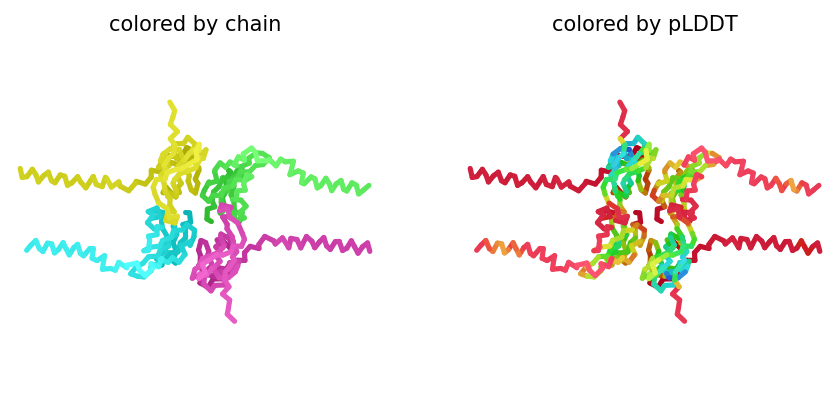

2024-11-13 21:53:04,607 alphafold2_multimer_v3_model_1_seed_002 recycle=0 pLDDT=56.4 pTM=0.281 ipTM=0.123
2024-11-13 21:53:18,041 alphafold2_multimer_v3_model_1_seed_002 recycle=1 pLDDT=58.2 pTM=0.298 ipTM=0.146 tol=10.9
2024-11-13 21:53:31,378 alphafold2_multimer_v3_model_1_seed_002 recycle=2 pLDDT=58.9 pTM=0.295 ipTM=0.137 tol=7.06
2024-11-13 21:53:44,822 alphafold2_multimer_v3_model_1_seed_002 recycle=3 pLDDT=58.7 pTM=0.295 ipTM=0.138 tol=2.24
2024-11-13 21:53:58,278 alphafold2_multimer_v3_model_1_seed_002 recycle=4 pLDDT=57.5 pTM=0.296 ipTM=0.14 tol=1.95
2024-11-13 21:54:11,736 alphafold2_multimer_v3_model_1_seed_002 recycle=5 pLDDT=58.2 pTM=0.293 ipTM=0.136 tol=4.44
2024-11-13 21:54:25,193 alphafold2_multimer_v3_model_1_seed_002 recycle=6 pLDDT=57.7 pTM=0.299 ipTM=0.141 tol=4.56
2024-11-13 21:54:38,643 alphafold2_multimer_v3_model_1_seed_002 recycle=7 pLDDT=59.2 pTM=0.293 ipTM=0.135 tol=3.44
2024-11-13 21:54:52,100 alphafold2_multimer_v3_model_1_seed_002 recycle=8 pLDDT=59.3 pTM=0

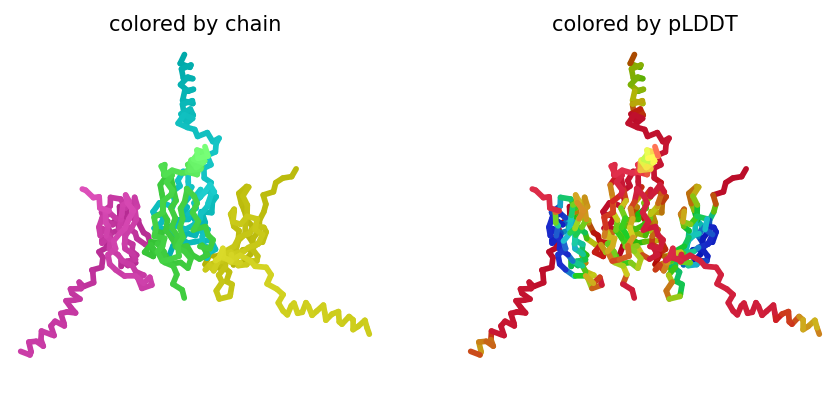

2024-11-13 21:57:46,648 alphafold2_multimer_v3_model_2_seed_002 recycle=0 pLDDT=60 pTM=0.295 ipTM=0.138
2024-11-13 21:58:00,063 alphafold2_multimer_v3_model_2_seed_002 recycle=1 pLDDT=60.8 pTM=0.292 ipTM=0.129 tol=7.96
2024-11-13 21:58:13,463 alphafold2_multimer_v3_model_2_seed_002 recycle=2 pLDDT=62 pTM=0.294 ipTM=0.134 tol=10.7
2024-11-13 21:58:26,840 alphafold2_multimer_v3_model_2_seed_002 recycle=3 pLDDT=61.7 pTM=0.29 ipTM=0.128 tol=2.27
2024-11-13 21:58:40,199 alphafold2_multimer_v3_model_2_seed_002 recycle=4 pLDDT=61.9 pTM=0.303 ipTM=0.151 tol=4.23
2024-11-13 21:58:53,542 alphafold2_multimer_v3_model_2_seed_002 recycle=5 pLDDT=62.1 pTM=0.306 ipTM=0.156 tol=3.68
2024-11-13 21:59:06,894 alphafold2_multimer_v3_model_2_seed_002 recycle=6 pLDDT=61.9 pTM=0.306 ipTM=0.151 tol=2.43
2024-11-13 21:59:20,245 alphafold2_multimer_v3_model_2_seed_002 recycle=7 pLDDT=62.3 pTM=0.306 ipTM=0.163 tol=1.47
2024-11-13 21:59:33,597 alphafold2_multimer_v3_model_2_seed_002 recycle=8 pLDDT=65.9 pTM=0.362

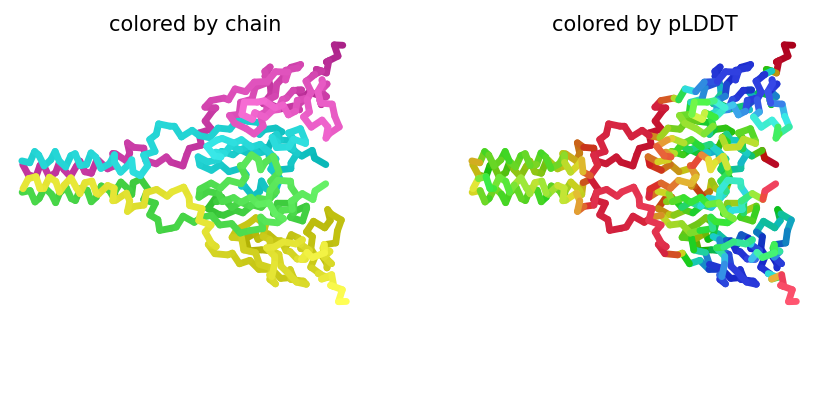

2024-11-13 22:01:47,808 alphafold2_multimer_v3_model_3_seed_002 recycle=0 pLDDT=58.8 pTM=0.293 ipTM=0.139
2024-11-13 22:02:01,198 alphafold2_multimer_v3_model_3_seed_002 recycle=1 pLDDT=57.5 pTM=0.275 ipTM=0.109 tol=17.1
2024-11-13 22:02:14,577 alphafold2_multimer_v3_model_3_seed_002 recycle=2 pLDDT=58 pTM=0.269 ipTM=0.104 tol=9.06
2024-11-13 22:02:27,966 alphafold2_multimer_v3_model_3_seed_002 recycle=3 pLDDT=58.2 pTM=0.27 ipTM=0.108 tol=12.1
2024-11-13 22:02:41,365 alphafold2_multimer_v3_model_3_seed_002 recycle=4 pLDDT=57.9 pTM=0.273 ipTM=0.108 tol=4.79
2024-11-13 22:02:54,784 alphafold2_multimer_v3_model_3_seed_002 recycle=5 pLDDT=56.3 pTM=0.279 ipTM=0.117 tol=9.09
2024-11-13 22:03:08,198 alphafold2_multimer_v3_model_3_seed_002 recycle=6 pLDDT=57.5 pTM=0.267 ipTM=0.0987 tol=8.86
2024-11-13 22:03:21,577 alphafold2_multimer_v3_model_3_seed_002 recycle=7 pLDDT=57.1 pTM=0.273 ipTM=0.11 tol=13.3
2024-11-13 22:03:35,052 alphafold2_multimer_v3_model_3_seed_002 recycle=8 pLDDT=56.9 pTM=0.2

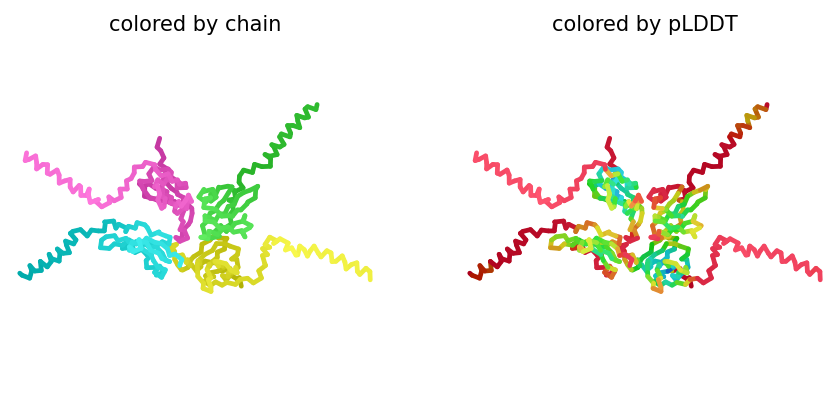

2024-11-13 22:06:30,493 alphafold2_multimer_v3_model_4_seed_002 recycle=0 pLDDT=59.9 pTM=0.302 ipTM=0.151
2024-11-13 22:06:43,961 alphafold2_multimer_v3_model_4_seed_002 recycle=1 pLDDT=60 pTM=0.296 ipTM=0.142 tol=9.1
2024-11-13 22:06:57,323 alphafold2_multimer_v3_model_4_seed_002 recycle=2 pLDDT=60.8 pTM=0.321 ipTM=0.181 tol=14.4
2024-11-13 22:07:10,690 alphafold2_multimer_v3_model_4_seed_002 recycle=3 pLDDT=59.3 pTM=0.308 ipTM=0.157 tol=4.26
2024-11-13 22:07:24,047 alphafold2_multimer_v3_model_4_seed_002 recycle=4 pLDDT=60.8 pTM=0.313 ipTM=0.146 tol=16.7
2024-11-13 22:07:37,405 alphafold2_multimer_v3_model_4_seed_002 recycle=5 pLDDT=60.7 pTM=0.312 ipTM=0.158 tol=1.81
2024-11-13 22:07:50,761 alphafold2_multimer_v3_model_4_seed_002 recycle=6 pLDDT=59.5 pTM=0.3 ipTM=0.146 tol=7.38
2024-11-13 22:08:04,120 alphafold2_multimer_v3_model_4_seed_002 recycle=7 pLDDT=59.2 pTM=0.303 ipTM=0.15 tol=4.53
2024-11-13 22:08:17,535 alphafold2_multimer_v3_model_4_seed_002 recycle=8 pLDDT=61 pTM=0.304 ip

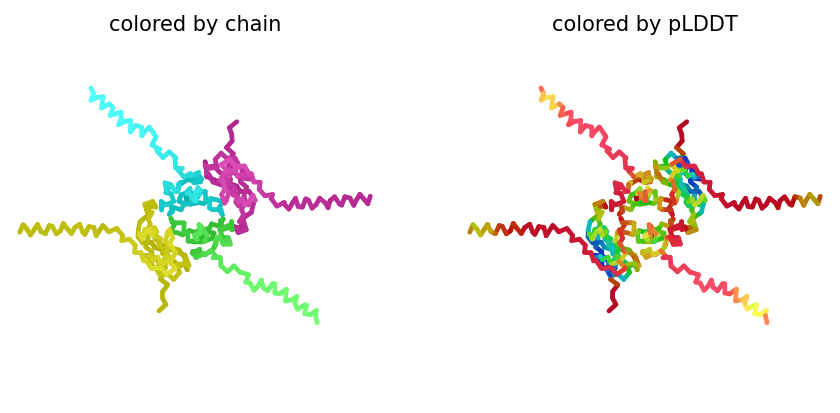

2024-11-13 22:11:12,422 alphafold2_multimer_v3_model_5_seed_002 recycle=0 pLDDT=56.3 pTM=0.288 ipTM=0.132
2024-11-13 22:11:25,901 alphafold2_multimer_v3_model_5_seed_002 recycle=1 pLDDT=56.3 pTM=0.281 ipTM=0.121 tol=6.99
2024-11-13 22:11:39,404 alphafold2_multimer_v3_model_5_seed_002 recycle=2 pLDDT=56 pTM=0.273 ipTM=0.11 tol=6.14
2024-11-13 22:11:52,888 alphafold2_multimer_v3_model_5_seed_002 recycle=3 pLDDT=57.9 pTM=0.273 ipTM=0.104 tol=7.82
2024-11-13 22:12:06,353 alphafold2_multimer_v3_model_5_seed_002 recycle=4 pLDDT=56.6 pTM=0.284 ipTM=0.119 tol=5.57
2024-11-13 22:12:19,817 alphafold2_multimer_v3_model_5_seed_002 recycle=5 pLDDT=57.6 pTM=0.283 ipTM=0.118 tol=2.79
2024-11-13 22:12:33,263 alphafold2_multimer_v3_model_5_seed_002 recycle=6 pLDDT=57.1 pTM=0.286 ipTM=0.122 tol=4.38
2024-11-13 22:12:46,710 alphafold2_multimer_v3_model_5_seed_002 recycle=7 pLDDT=57.1 pTM=0.284 ipTM=0.118 tol=4.36
2024-11-13 22:13:00,067 alphafold2_multimer_v3_model_5_seed_002 recycle=8 pLDDT=57.1 pTM=0.2

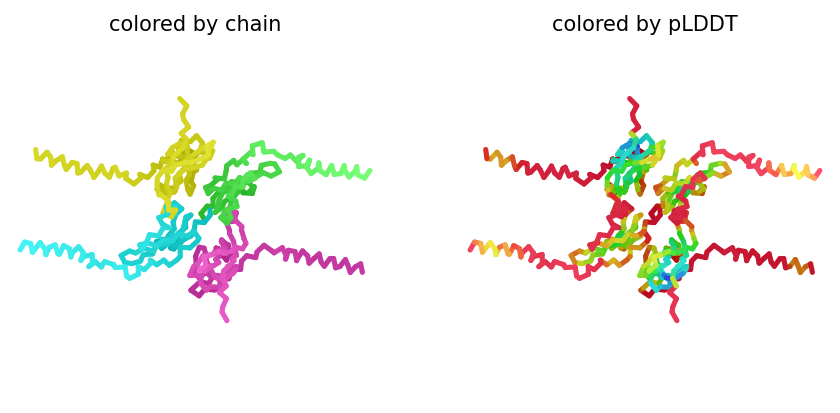

2024-11-13 22:15:54,778 alphafold2_multimer_v3_model_1_seed_003 recycle=0 pLDDT=57.9 pTM=0.289 ipTM=0.138
2024-11-13 22:16:08,148 alphafold2_multimer_v3_model_1_seed_003 recycle=1 pLDDT=59.9 pTM=0.319 ipTM=0.208 tol=8.66
2024-11-13 22:16:21,489 alphafold2_multimer_v3_model_1_seed_003 recycle=2 pLDDT=60 pTM=0.31 ipTM=0.167 tol=6.22
2024-11-13 22:16:34,846 alphafold2_multimer_v3_model_1_seed_003 recycle=3 pLDDT=58.9 pTM=0.294 ipTM=0.138 tol=4.18
2024-11-13 22:16:48,216 alphafold2_multimer_v3_model_1_seed_003 recycle=4 pLDDT=58.6 pTM=0.29 ipTM=0.132 tol=8.34
2024-11-13 22:17:01,667 alphafold2_multimer_v3_model_1_seed_003 recycle=5 pLDDT=58.2 pTM=0.289 ipTM=0.13 tol=3.76
2024-11-13 22:17:15,127 alphafold2_multimer_v3_model_1_seed_003 recycle=6 pLDDT=58.6 pTM=0.289 ipTM=0.129 tol=4.36
2024-11-13 22:17:28,590 alphafold2_multimer_v3_model_1_seed_003 recycle=7 pLDDT=58.5 pTM=0.3 ipTM=0.143 tol=3.71
2024-11-13 22:17:41,951 alphafold2_multimer_v3_model_1_seed_003 recycle=8 pLDDT=58.3 pTM=0.294 i

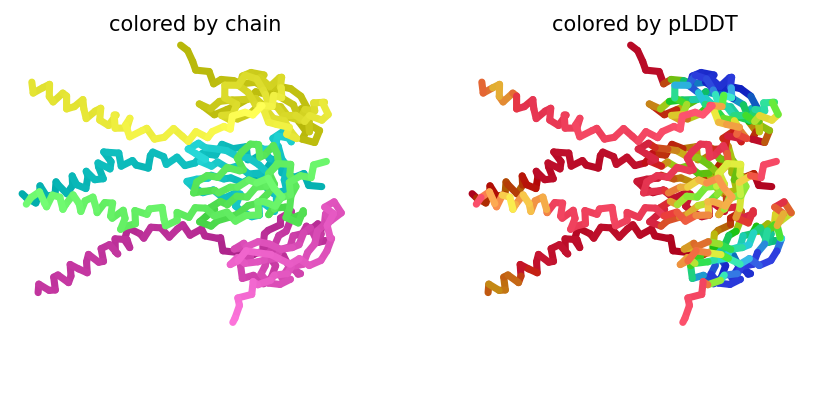

2024-11-13 22:20:36,888 alphafold2_multimer_v3_model_2_seed_003 recycle=0 pLDDT=59 pTM=0.294 ipTM=0.136
2024-11-13 22:20:50,273 alphafold2_multimer_v3_model_2_seed_003 recycle=1 pLDDT=60.3 pTM=0.291 ipTM=0.13 tol=3.8
2024-11-13 22:21:03,748 alphafold2_multimer_v3_model_2_seed_003 recycle=2 pLDDT=61.4 pTM=0.291 ipTM=0.13 tol=10.7
2024-11-13 22:21:17,099 alphafold2_multimer_v3_model_2_seed_003 recycle=3 pLDDT=62.3 pTM=0.304 ipTM=0.159 tol=8.36
2024-11-13 22:21:30,532 alphafold2_multimer_v3_model_2_seed_003 recycle=4 pLDDT=62.1 pTM=0.298 ipTM=0.168 tol=1.14
2024-11-13 22:21:43,934 alphafold2_multimer_v3_model_2_seed_003 recycle=5 pLDDT=62.2 pTM=0.305 ipTM=0.178 tol=1.1
2024-11-13 22:21:57,242 alphafold2_multimer_v3_model_2_seed_003 recycle=6 pLDDT=62.3 pTM=0.304 ipTM=0.171 tol=1.07
2024-11-13 22:22:10,574 alphafold2_multimer_v3_model_2_seed_003 recycle=7 pLDDT=62.5 pTM=0.314 ipTM=0.184 tol=0.897
2024-11-13 22:22:23,920 alphafold2_multimer_v3_model_2_seed_003 recycle=8 pLDDT=62.3 pTM=0.303

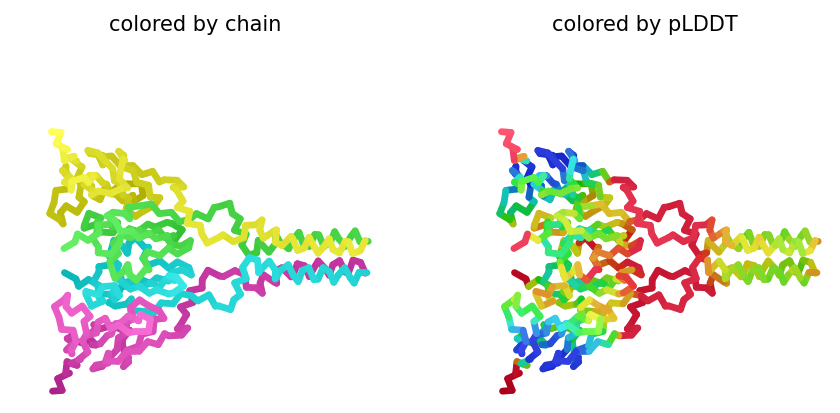

2024-11-13 22:25:18,270 alphafold2_multimer_v3_model_3_seed_003 recycle=0 pLDDT=58.9 pTM=0.277 ipTM=0.117
2024-11-13 22:25:31,663 alphafold2_multimer_v3_model_3_seed_003 recycle=1 pLDDT=56.7 pTM=0.281 ipTM=0.119 tol=10.5
2024-11-13 22:25:45,058 alphafold2_multimer_v3_model_3_seed_003 recycle=2 pLDDT=56.8 pTM=0.277 ipTM=0.112 tol=8.19
2024-11-13 22:25:58,473 alphafold2_multimer_v3_model_3_seed_003 recycle=3 pLDDT=57.4 pTM=0.27 ipTM=0.111 tol=6.2
2024-11-13 22:26:11,884 alphafold2_multimer_v3_model_3_seed_003 recycle=4 pLDDT=57.6 pTM=0.271 ipTM=0.11 tol=8.1
2024-11-13 22:26:25,287 alphafold2_multimer_v3_model_3_seed_003 recycle=5 pLDDT=57.4 pTM=0.276 ipTM=0.114 tol=3.99
2024-11-13 22:26:38,711 alphafold2_multimer_v3_model_3_seed_003 recycle=6 pLDDT=56.7 pTM=0.27 ipTM=0.102 tol=12.5
2024-11-13 22:26:52,133 alphafold2_multimer_v3_model_3_seed_003 recycle=7 pLDDT=56.5 pTM=0.274 ipTM=0.106 tol=9.91
2024-11-13 22:27:05,531 alphafold2_multimer_v3_model_3_seed_003 recycle=8 pLDDT=56.5 pTM=0.276

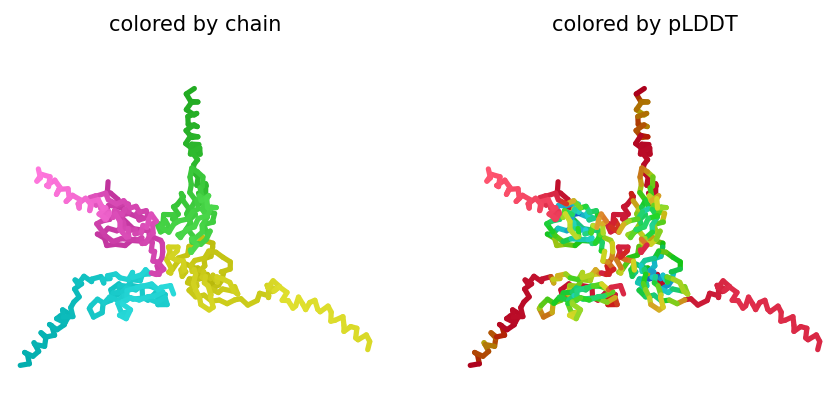

2024-11-13 22:30:00,562 alphafold2_multimer_v3_model_4_seed_003 recycle=0 pLDDT=58.8 pTM=0.287 ipTM=0.136
2024-11-13 22:30:14,008 alphafold2_multimer_v3_model_4_seed_003 recycle=1 pLDDT=59.2 pTM=0.3 ipTM=0.143 tol=10.6
2024-11-13 22:30:27,444 alphafold2_multimer_v3_model_4_seed_003 recycle=2 pLDDT=59.4 pTM=0.305 ipTM=0.156 tol=5.32
2024-11-13 22:30:40,886 alphafold2_multimer_v3_model_4_seed_003 recycle=3 pLDDT=60.4 pTM=0.302 ipTM=0.141 tol=13.2
2024-11-13 22:30:54,337 alphafold2_multimer_v3_model_4_seed_003 recycle=4 pLDDT=60 pTM=0.308 ipTM=0.148 tol=2.94
2024-11-13 22:31:07,781 alphafold2_multimer_v3_model_4_seed_003 recycle=5 pLDDT=59.6 pTM=0.306 ipTM=0.15 tol=2.61
2024-11-13 22:31:21,225 alphafold2_multimer_v3_model_4_seed_003 recycle=6 pLDDT=60.3 pTM=0.311 ipTM=0.154 tol=2.46
2024-11-13 22:31:34,672 alphafold2_multimer_v3_model_4_seed_003 recycle=7 pLDDT=59.5 pTM=0.305 ipTM=0.148 tol=3.32
2024-11-13 22:31:48,116 alphafold2_multimer_v3_model_4_seed_003 recycle=8 pLDDT=59.8 pTM=0.3 i

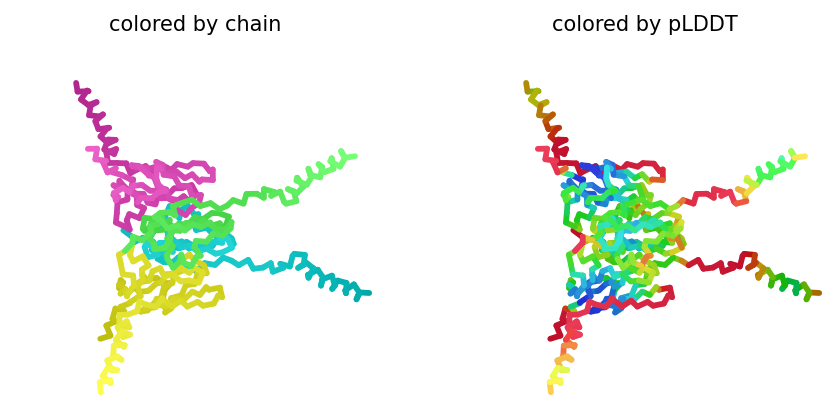

2024-11-13 22:34:42,394 alphafold2_multimer_v3_model_5_seed_003 recycle=0 pLDDT=57.8 pTM=0.276 ipTM=0.126
2024-11-13 22:34:55,781 alphafold2_multimer_v3_model_5_seed_003 recycle=1 pLDDT=57.2 pTM=0.284 ipTM=0.13 tol=8.22
2024-11-13 22:35:09,187 alphafold2_multimer_v3_model_5_seed_003 recycle=2 pLDDT=56.3 pTM=0.279 ipTM=0.114 tol=7.46
2024-11-13 22:35:22,587 alphafold2_multimer_v3_model_5_seed_003 recycle=3 pLDDT=56.8 pTM=0.278 ipTM=0.115 tol=4.35
2024-11-13 22:35:35,980 alphafold2_multimer_v3_model_5_seed_003 recycle=4 pLDDT=56 pTM=0.278 ipTM=0.115 tol=4.09
2024-11-13 22:35:49,383 alphafold2_multimer_v3_model_5_seed_003 recycle=5 pLDDT=56.2 pTM=0.28 ipTM=0.118 tol=2.79
2024-11-13 22:36:02,783 alphafold2_multimer_v3_model_5_seed_003 recycle=6 pLDDT=55.8 pTM=0.278 ipTM=0.118 tol=4.27
2024-11-13 22:36:16,181 alphafold2_multimer_v3_model_5_seed_003 recycle=7 pLDDT=55.5 pTM=0.279 ipTM=0.117 tol=3.12
2024-11-13 22:36:29,571 alphafold2_multimer_v3_model_5_seed_003 recycle=8 pLDDT=55.8 pTM=0.28

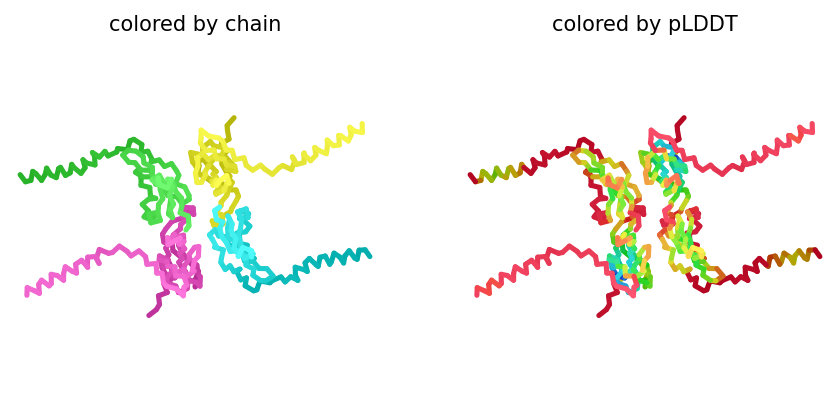

2024-11-13 22:39:24,177 alphafold2_multimer_v3_model_1_seed_004 recycle=0 pLDDT=56.8 pTM=0.269 ipTM=0.122
2024-11-13 22:39:37,554 alphafold2_multimer_v3_model_1_seed_004 recycle=1 pLDDT=58.2 pTM=0.288 ipTM=0.127 tol=11.1
2024-11-13 22:39:50,932 alphafold2_multimer_v3_model_1_seed_004 recycle=2 pLDDT=58.3 pTM=0.294 ipTM=0.135 tol=4.26
2024-11-13 22:40:04,330 alphafold2_multimer_v3_model_1_seed_004 recycle=3 pLDDT=58.1 pTM=0.294 ipTM=0.136 tol=4.19
2024-11-13 22:40:17,705 alphafold2_multimer_v3_model_1_seed_004 recycle=4 pLDDT=58.4 pTM=0.294 ipTM=0.137 tol=4.12
2024-11-13 22:40:31,103 alphafold2_multimer_v3_model_1_seed_004 recycle=5 pLDDT=57.3 pTM=0.295 ipTM=0.136 tol=4.21
2024-11-13 22:40:44,539 alphafold2_multimer_v3_model_1_seed_004 recycle=6 pLDDT=57.4 pTM=0.297 ipTM=0.141 tol=3.28
2024-11-13 22:40:57,968 alphafold2_multimer_v3_model_1_seed_004 recycle=7 pLDDT=58.6 pTM=0.294 ipTM=0.136 tol=2.59
2024-11-13 22:41:11,302 alphafold2_multimer_v3_model_1_seed_004 recycle=8 pLDDT=57.7 pTM=

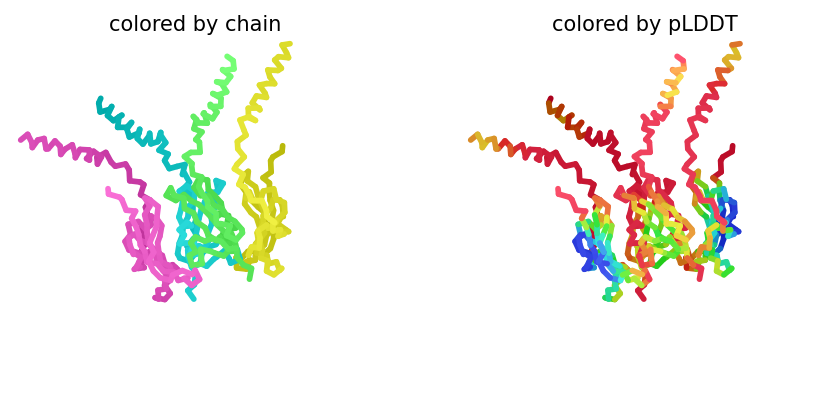

2024-11-13 22:44:06,279 alphafold2_multimer_v3_model_2_seed_004 recycle=0 pLDDT=58.9 pTM=0.286 ipTM=0.125
2024-11-13 22:44:19,738 alphafold2_multimer_v3_model_2_seed_004 recycle=1 pLDDT=61.1 pTM=0.304 ipTM=0.147 tol=11.5
2024-11-13 22:44:33,168 alphafold2_multimer_v3_model_2_seed_004 recycle=2 pLDDT=61.2 pTM=0.314 ipTM=0.159 tol=7.7
2024-11-13 22:44:46,592 alphafold2_multimer_v3_model_2_seed_004 recycle=3 pLDDT=61 pTM=0.302 ipTM=0.145 tol=1.65
2024-11-13 22:45:00,025 alphafold2_multimer_v3_model_2_seed_004 recycle=4 pLDDT=61.5 pTM=0.3 ipTM=0.144 tol=1.54
2024-11-13 22:45:13,445 alphafold2_multimer_v3_model_2_seed_004 recycle=5 pLDDT=61.3 pTM=0.304 ipTM=0.149 tol=0.797
2024-11-13 22:45:26,875 alphafold2_multimer_v3_model_2_seed_004 recycle=6 pLDDT=61.8 pTM=0.309 ipTM=0.169 tol=1.1
2024-11-13 22:45:40,302 alphafold2_multimer_v3_model_2_seed_004 recycle=7 pLDDT=62 pTM=0.309 ipTM=0.169 tol=1.26
2024-11-13 22:45:53,733 alphafold2_multimer_v3_model_2_seed_004 recycle=8 pLDDT=62.2 pTM=0.3 ipT

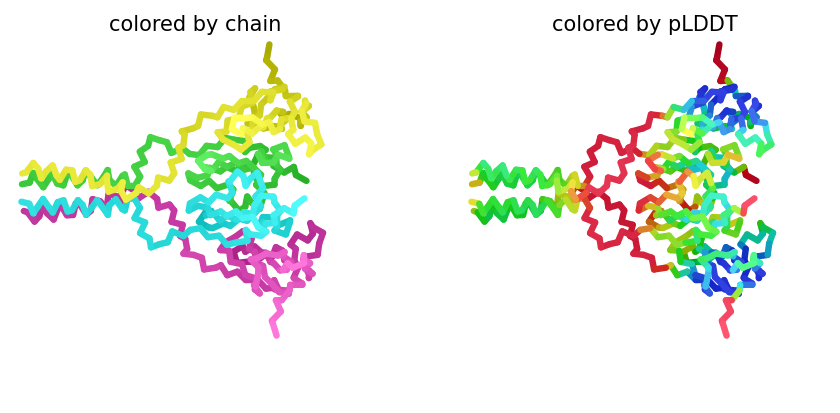

2024-11-13 22:48:34,686 alphafold2_multimer_v3_model_3_seed_004 recycle=0 pLDDT=57.2 pTM=0.274 ipTM=0.117
2024-11-13 22:48:48,149 alphafold2_multimer_v3_model_3_seed_004 recycle=1 pLDDT=56.5 pTM=0.274 ipTM=0.108 tol=5.61
2024-11-13 22:49:01,616 alphafold2_multimer_v3_model_3_seed_004 recycle=2 pLDDT=57.2 pTM=0.281 ipTM=0.118 tol=7.72
2024-11-13 22:49:15,065 alphafold2_multimer_v3_model_3_seed_004 recycle=3 pLDDT=57.3 pTM=0.281 ipTM=0.119 tol=8.87
2024-11-13 22:49:28,459 alphafold2_multimer_v3_model_3_seed_004 recycle=4 pLDDT=58 pTM=0.267 ipTM=0.108 tol=7.54
2024-11-13 22:49:41,868 alphafold2_multimer_v3_model_3_seed_004 recycle=5 pLDDT=58 pTM=0.27 ipTM=0.104 tol=6.44
2024-11-13 22:49:55,345 alphafold2_multimer_v3_model_3_seed_004 recycle=6 pLDDT=58 pTM=0.273 ipTM=0.11 tol=4.04
2024-11-13 22:50:08,827 alphafold2_multimer_v3_model_3_seed_004 recycle=7 pLDDT=58.4 pTM=0.273 ipTM=0.109 tol=3.11
2024-11-13 22:50:22,307 alphafold2_multimer_v3_model_3_seed_004 recycle=8 pLDDT=58.8 pTM=0.267 ip

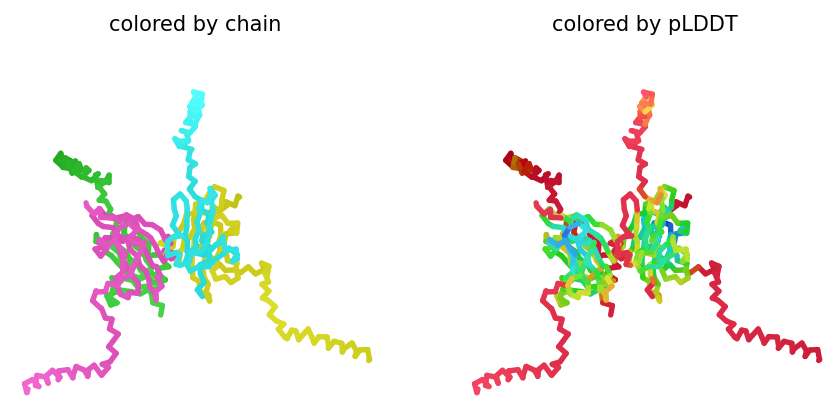

2024-11-13 22:53:17,888 alphafold2_multimer_v3_model_4_seed_004 recycle=0 pLDDT=60.3 pTM=0.298 ipTM=0.146
2024-11-13 22:53:31,254 alphafold2_multimer_v3_model_4_seed_004 recycle=1 pLDDT=59.3 pTM=0.304 ipTM=0.152 tol=7.9
2024-11-13 22:53:44,624 alphafold2_multimer_v3_model_4_seed_004 recycle=2 pLDDT=59.7 pTM=0.305 ipTM=0.149 tol=7.21
2024-11-13 22:53:57,998 alphafold2_multimer_v3_model_4_seed_004 recycle=3 pLDDT=60.3 pTM=0.306 ipTM=0.152 tol=3.85
2024-11-13 22:54:11,457 alphafold2_multimer_v3_model_4_seed_004 recycle=4 pLDDT=61.2 pTM=0.298 ipTM=0.14 tol=8.41
2024-11-13 22:54:24,811 alphafold2_multimer_v3_model_4_seed_004 recycle=5 pLDDT=60.1 pTM=0.3 ipTM=0.147 tol=8.09
2024-11-13 22:54:38,178 alphafold2_multimer_v3_model_4_seed_004 recycle=6 pLDDT=59.2 pTM=0.302 ipTM=0.147 tol=4.24
2024-11-13 22:54:51,547 alphafold2_multimer_v3_model_4_seed_004 recycle=7 pLDDT=61.3 pTM=0.309 ipTM=0.146 tol=10.9
2024-11-13 22:55:04,918 alphafold2_multimer_v3_model_4_seed_004 recycle=8 pLDDT=60 pTM=0.302 

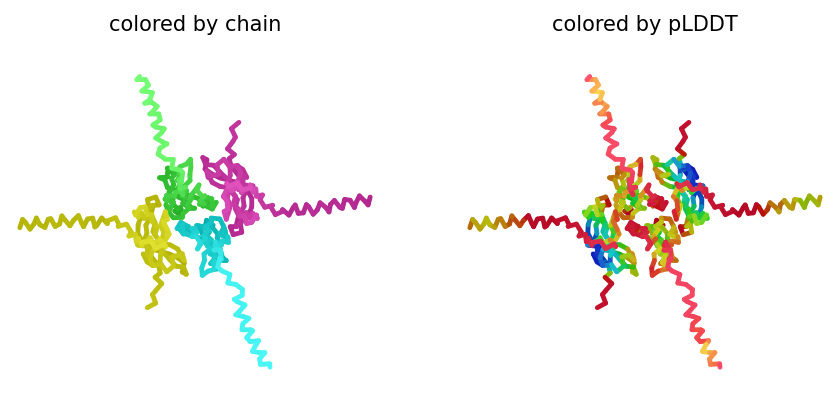

2024-11-13 22:57:59,651 alphafold2_multimer_v3_model_5_seed_004 recycle=0 pLDDT=56.8 pTM=0.274 ipTM=0.111
2024-11-13 22:58:13,027 alphafold2_multimer_v3_model_5_seed_004 recycle=1 pLDDT=56.2 pTM=0.27 ipTM=0.111 tol=7.01
2024-11-13 22:58:26,423 alphafold2_multimer_v3_model_5_seed_004 recycle=2 pLDDT=56.2 pTM=0.276 ipTM=0.115 tol=4.02
2024-11-13 22:58:39,824 alphafold2_multimer_v3_model_5_seed_004 recycle=3 pLDDT=56.1 pTM=0.278 ipTM=0.118 tol=5.78
2024-11-13 22:58:53,222 alphafold2_multimer_v3_model_5_seed_004 recycle=4 pLDDT=56.4 pTM=0.28 ipTM=0.118 tol=3.81
2024-11-13 22:59:06,609 alphafold2_multimer_v3_model_5_seed_004 recycle=5 pLDDT=56.5 pTM=0.281 ipTM=0.12 tol=5.54
2024-11-13 22:59:20,017 alphafold2_multimer_v3_model_5_seed_004 recycle=6 pLDDT=55.8 pTM=0.277 ipTM=0.119 tol=8.05
2024-11-13 22:59:33,406 alphafold2_multimer_v3_model_5_seed_004 recycle=7 pLDDT=56.6 pTM=0.281 ipTM=0.112 tol=5.78
2024-11-13 22:59:46,783 alphafold2_multimer_v3_model_5_seed_004 recycle=8 pLDDT=56.8 pTM=0.2

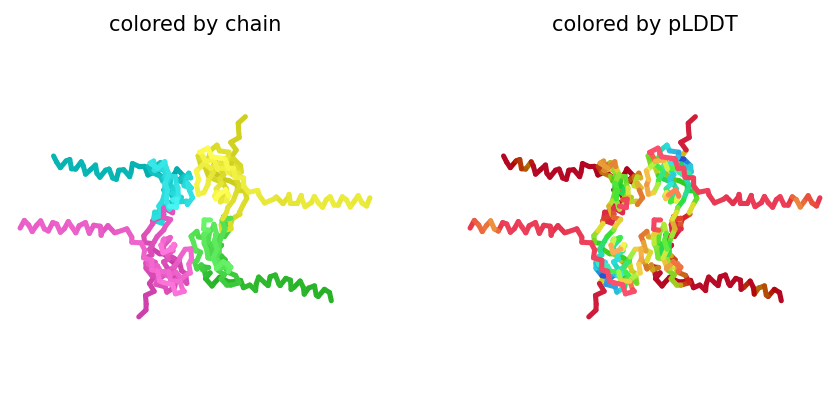

2024-11-13 23:02:41,462 alphafold2_multimer_v3_model_1_seed_005 recycle=0 pLDDT=57.2 pTM=0.282 ipTM=0.124
2024-11-13 23:02:54,910 alphafold2_multimer_v3_model_1_seed_005 recycle=1 pLDDT=58.7 pTM=0.295 ipTM=0.136 tol=4.61
2024-11-13 23:03:08,335 alphafold2_multimer_v3_model_1_seed_005 recycle=2 pLDDT=58 pTM=0.286 ipTM=0.124 tol=3.43
2024-11-13 23:03:21,694 alphafold2_multimer_v3_model_1_seed_005 recycle=3 pLDDT=60.1 pTM=0.287 ipTM=0.128 tol=2.7
2024-11-13 23:03:35,061 alphafold2_multimer_v3_model_1_seed_005 recycle=4 pLDDT=59.1 pTM=0.287 ipTM=0.127 tol=2.22
2024-11-13 23:03:48,429 alphafold2_multimer_v3_model_1_seed_005 recycle=5 pLDDT=59.9 pTM=0.295 ipTM=0.139 tol=4.87
2024-11-13 23:04:01,819 alphafold2_multimer_v3_model_1_seed_005 recycle=6 pLDDT=59.4 pTM=0.299 ipTM=0.141 tol=6.66
2024-11-13 23:04:15,200 alphafold2_multimer_v3_model_1_seed_005 recycle=7 pLDDT=58.5 pTM=0.295 ipTM=0.138 tol=3.12
2024-11-13 23:04:28,589 alphafold2_multimer_v3_model_1_seed_005 recycle=8 pLDDT=58 pTM=0.298

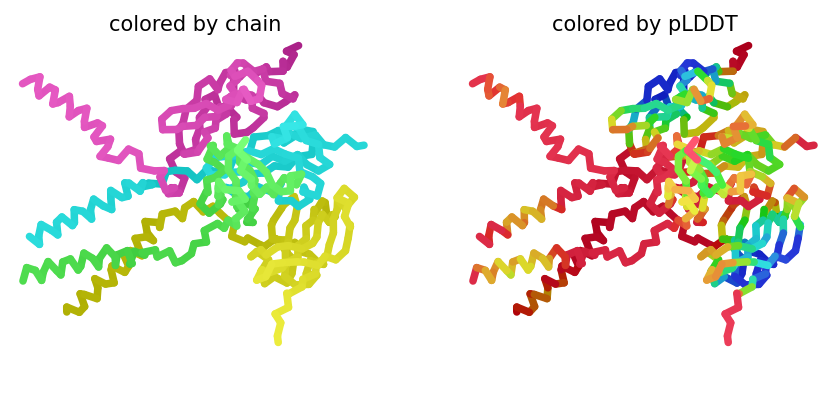

2024-11-13 23:07:23,217 alphafold2_multimer_v3_model_2_seed_005 recycle=0 pLDDT=59.8 pTM=0.287 ipTM=0.126
2024-11-13 23:07:36,586 alphafold2_multimer_v3_model_2_seed_005 recycle=1 pLDDT=60.8 pTM=0.284 ipTM=0.121 tol=4.38
2024-11-13 23:07:49,970 alphafold2_multimer_v3_model_2_seed_005 recycle=2 pLDDT=60.2 pTM=0.287 ipTM=0.122 tol=4.08
2024-11-13 23:08:03,361 alphafold2_multimer_v3_model_2_seed_005 recycle=3 pLDDT=61.2 pTM=0.287 ipTM=0.126 tol=4.26
2024-11-13 23:08:16,728 alphafold2_multimer_v3_model_2_seed_005 recycle=4 pLDDT=60 pTM=0.281 ipTM=0.117 tol=3.48
2024-11-13 23:08:30,103 alphafold2_multimer_v3_model_2_seed_005 recycle=5 pLDDT=61.3 pTM=0.291 ipTM=0.128 tol=5.09
2024-11-13 23:08:43,540 alphafold2_multimer_v3_model_2_seed_005 recycle=6 pLDDT=62.4 pTM=0.29 ipTM=0.129 tol=2.01
2024-11-13 23:08:56,906 alphafold2_multimer_v3_model_2_seed_005 recycle=7 pLDDT=66.5 pTM=0.376 ipTM=0.266 tol=8.59
2024-11-13 23:09:10,251 alphafold2_multimer_v3_model_2_seed_005 recycle=8 pLDDT=68.1 pTM=0.4

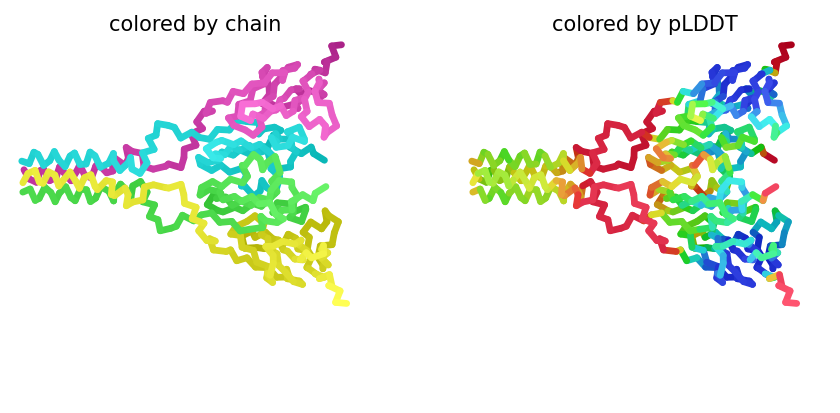

2024-11-13 23:10:17,613 alphafold2_multimer_v3_model_3_seed_005 recycle=0 pLDDT=58.4 pTM=0.294 ipTM=0.141
2024-11-13 23:10:30,980 alphafold2_multimer_v3_model_3_seed_005 recycle=1 pLDDT=58.8 pTM=0.28 ipTM=0.118 tol=8.23
2024-11-13 23:10:44,358 alphafold2_multimer_v3_model_3_seed_005 recycle=2 pLDDT=57.7 pTM=0.274 ipTM=0.111 tol=4.39
2024-11-13 23:10:57,838 alphafold2_multimer_v3_model_3_seed_005 recycle=3 pLDDT=57.8 pTM=0.271 ipTM=0.106 tol=11.6
2024-11-13 23:11:11,331 alphafold2_multimer_v3_model_3_seed_005 recycle=4 pLDDT=57.4 pTM=0.273 ipTM=0.108 tol=6.99
2024-11-13 23:11:24,826 alphafold2_multimer_v3_model_3_seed_005 recycle=5 pLDDT=57.9 pTM=0.274 ipTM=0.111 tol=4.68
2024-11-13 23:11:38,310 alphafold2_multimer_v3_model_3_seed_005 recycle=6 pLDDT=57.2 pTM=0.277 ipTM=0.111 tol=4.55
2024-11-13 23:11:51,776 alphafold2_multimer_v3_model_3_seed_005 recycle=7 pLDDT=56.8 pTM=0.274 ipTM=0.113 tol=5.2
2024-11-13 23:12:05,241 alphafold2_multimer_v3_model_3_seed_005 recycle=8 pLDDT=57.1 pTM=0.

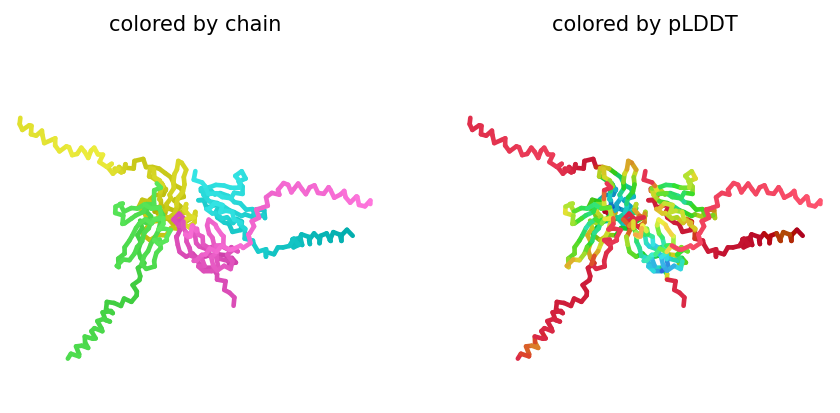

2024-11-13 23:15:00,476 alphafold2_multimer_v3_model_4_seed_005 recycle=0 pLDDT=60.6 pTM=0.306 ipTM=0.152
2024-11-13 23:15:13,846 alphafold2_multimer_v3_model_4_seed_005 recycle=1 pLDDT=60 pTM=0.302 ipTM=0.148 tol=8.3
2024-11-13 23:15:27,213 alphafold2_multimer_v3_model_4_seed_005 recycle=2 pLDDT=60.4 pTM=0.308 ipTM=0.154 tol=9.21
2024-11-13 23:15:40,598 alphafold2_multimer_v3_model_4_seed_005 recycle=3 pLDDT=60.2 pTM=0.302 ipTM=0.142 tol=4.28
2024-11-13 23:15:53,991 alphafold2_multimer_v3_model_4_seed_005 recycle=4 pLDDT=60 pTM=0.307 ipTM=0.146 tol=3.59
2024-11-13 23:16:07,363 alphafold2_multimer_v3_model_4_seed_005 recycle=5 pLDDT=61.9 pTM=0.311 ipTM=0.153 tol=8.73
2024-11-13 23:16:20,734 alphafold2_multimer_v3_model_4_seed_005 recycle=6 pLDDT=60 pTM=0.309 ipTM=0.15 tol=3.67
2024-11-13 23:16:34,098 alphafold2_multimer_v3_model_4_seed_005 recycle=7 pLDDT=59.5 pTM=0.31 ipTM=0.151 tol=2.74
2024-11-13 23:16:47,467 alphafold2_multimer_v3_model_4_seed_005 recycle=8 pLDDT=59.5 pTM=0.315 ipT

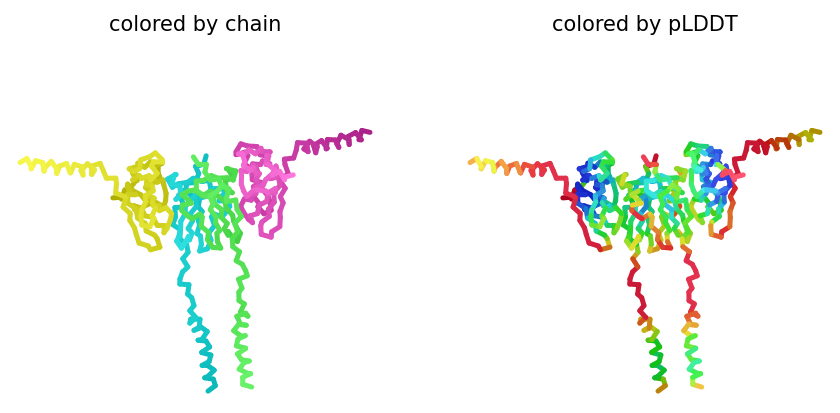

2024-11-13 23:19:41,933 alphafold2_multimer_v3_model_5_seed_005 recycle=0 pLDDT=57.9 pTM=0.304 ipTM=0.164
2024-11-13 23:19:55,347 alphafold2_multimer_v3_model_5_seed_005 recycle=1 pLDDT=56.8 pTM=0.285 ipTM=0.125 tol=7.59
2024-11-13 23:20:08,745 alphafold2_multimer_v3_model_5_seed_005 recycle=2 pLDDT=56.4 pTM=0.295 ipTM=0.133 tol=7.5
2024-11-13 23:20:22,131 alphafold2_multimer_v3_model_5_seed_005 recycle=3 pLDDT=56.9 pTM=0.291 ipTM=0.123 tol=6.49
2024-11-13 23:20:35,514 alphafold2_multimer_v3_model_5_seed_005 recycle=4 pLDDT=56 pTM=0.286 ipTM=0.12 tol=1.97
2024-11-13 23:20:48,903 alphafold2_multimer_v3_model_5_seed_005 recycle=5 pLDDT=56.6 pTM=0.288 ipTM=0.123 tol=2.37
2024-11-13 23:21:02,285 alphafold2_multimer_v3_model_5_seed_005 recycle=6 pLDDT=56.9 pTM=0.288 ipTM=0.124 tol=3.27
2024-11-13 23:21:15,658 alphafold2_multimer_v3_model_5_seed_005 recycle=7 pLDDT=56.4 pTM=0.288 ipTM=0.123 tol=2.33
2024-11-13 23:21:29,118 alphafold2_multimer_v3_model_5_seed_005 recycle=8 pLDDT=56.8 pTM=0.28

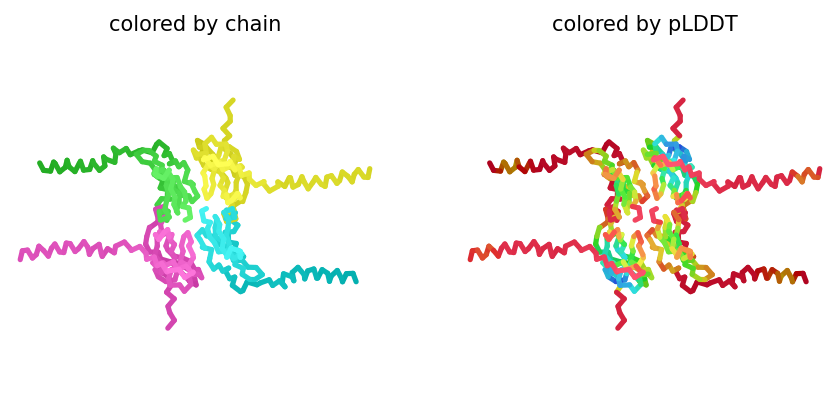

2024-11-13 23:24:23,657 alphafold2_multimer_v3_model_1_seed_006 recycle=0 pLDDT=59.2 pTM=0.3 ipTM=0.168
2024-11-13 23:24:37,040 alphafold2_multimer_v3_model_1_seed_006 recycle=1 pLDDT=59 pTM=0.305 ipTM=0.151 tol=7.06
2024-11-13 23:24:50,415 alphafold2_multimer_v3_model_1_seed_006 recycle=2 pLDDT=58.2 pTM=0.299 ipTM=0.142 tol=2.73
2024-11-13 23:25:03,795 alphafold2_multimer_v3_model_1_seed_006 recycle=3 pLDDT=58.1 pTM=0.296 ipTM=0.141 tol=2.01
2024-11-13 23:25:17,242 alphafold2_multimer_v3_model_1_seed_006 recycle=4 pLDDT=58.5 pTM=0.297 ipTM=0.139 tol=1.87
2024-11-13 23:25:30,676 alphafold2_multimer_v3_model_1_seed_006 recycle=5 pLDDT=58.8 pTM=0.299 ipTM=0.143 tol=3.19
2024-11-13 23:25:44,088 alphafold2_multimer_v3_model_1_seed_006 recycle=6 pLDDT=59 pTM=0.302 ipTM=0.147 tol=2.02
2024-11-13 23:25:57,409 alphafold2_multimer_v3_model_1_seed_006 recycle=7 pLDDT=58.6 pTM=0.297 ipTM=0.14 tol=1.57
2024-11-13 23:26:10,766 alphafold2_multimer_v3_model_1_seed_006 recycle=8 pLDDT=58.6 pTM=0.295 i

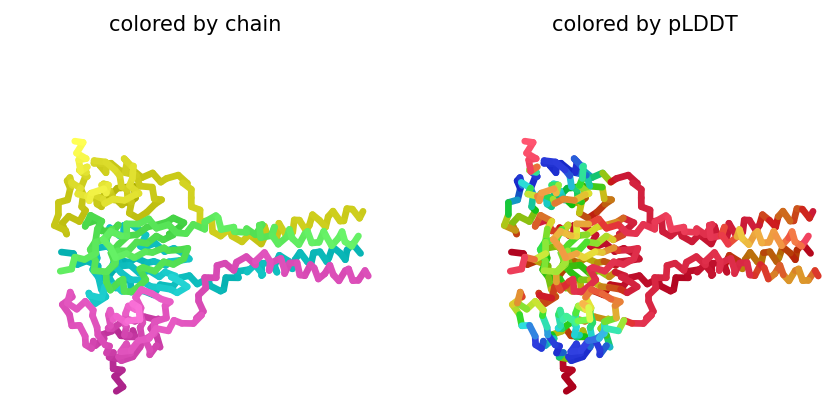

2024-11-13 23:29:05,481 alphafold2_multimer_v3_model_2_seed_006 recycle=0 pLDDT=60.1 pTM=0.292 ipTM=0.134
2024-11-13 23:29:18,915 alphafold2_multimer_v3_model_2_seed_006 recycle=1 pLDDT=61.3 pTM=0.287 ipTM=0.126 tol=5.25
2024-11-13 23:29:32,346 alphafold2_multimer_v3_model_2_seed_006 recycle=2 pLDDT=61 pTM=0.291 ipTM=0.131 tol=4.7
2024-11-13 23:29:45,791 alphafold2_multimer_v3_model_2_seed_006 recycle=3 pLDDT=61 pTM=0.292 ipTM=0.131 tol=4.81
2024-11-13 23:29:59,226 alphafold2_multimer_v3_model_2_seed_006 recycle=4 pLDDT=62.2 pTM=0.296 ipTM=0.137 tol=2.61
2024-11-13 23:30:12,658 alphafold2_multimer_v3_model_2_seed_006 recycle=5 pLDDT=61.7 pTM=0.302 ipTM=0.145 tol=5
2024-11-13 23:30:26,083 alphafold2_multimer_v3_model_2_seed_006 recycle=6 pLDDT=61.6 pTM=0.301 ipTM=0.153 tol=3.54
2024-11-13 23:30:39,507 alphafold2_multimer_v3_model_2_seed_006 recycle=7 pLDDT=65 pTM=0.374 ipTM=0.263 tol=3.6
2024-11-13 23:30:52,824 alphafold2_multimer_v3_model_2_seed_006 recycle=8 pLDDT=69 pTM=0.428 ipTM=0.

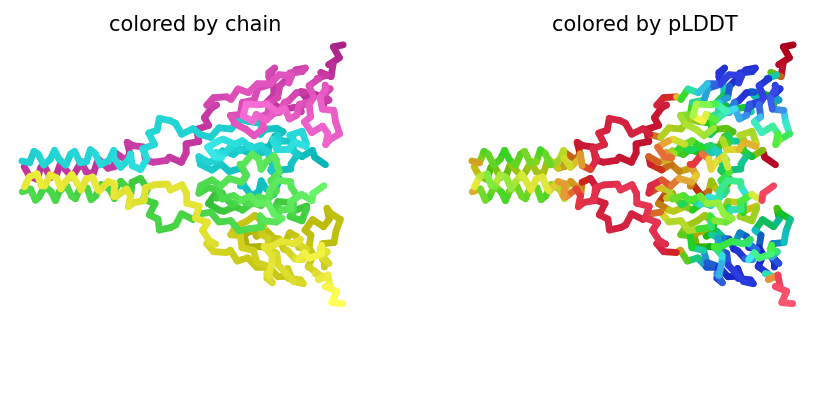

2024-11-13 23:31:33,427 alphafold2_multimer_v3_model_3_seed_006 recycle=0 pLDDT=59.1 pTM=0.314 ipTM=0.165
2024-11-13 23:31:46,789 alphafold2_multimer_v3_model_3_seed_006 recycle=1 pLDDT=60.4 pTM=0.308 ipTM=0.154 tol=10.5
2024-11-13 23:32:00,156 alphafold2_multimer_v3_model_3_seed_006 recycle=2 pLDDT=59.8 pTM=0.301 ipTM=0.142 tol=1.84
2024-11-13 23:32:13,522 alphafold2_multimer_v3_model_3_seed_006 recycle=3 pLDDT=59 pTM=0.297 ipTM=0.138 tol=2.17
2024-11-13 23:32:26,880 alphafold2_multimer_v3_model_3_seed_006 recycle=4 pLDDT=59.3 pTM=0.294 ipTM=0.135 tol=1.65
2024-11-13 23:32:40,254 alphafold2_multimer_v3_model_3_seed_006 recycle=5 pLDDT=59 pTM=0.297 ipTM=0.14 tol=1.34
2024-11-13 23:32:53,619 alphafold2_multimer_v3_model_3_seed_006 recycle=6 pLDDT=58.5 pTM=0.293 ipTM=0.135 tol=2.1
2024-11-13 23:33:07,079 alphafold2_multimer_v3_model_3_seed_006 recycle=7 pLDDT=58.1 pTM=0.28 ipTM=0.119 tol=13.4
2024-11-13 23:33:20,554 alphafold2_multimer_v3_model_3_seed_006 recycle=8 pLDDT=58 pTM=0.277 ipT

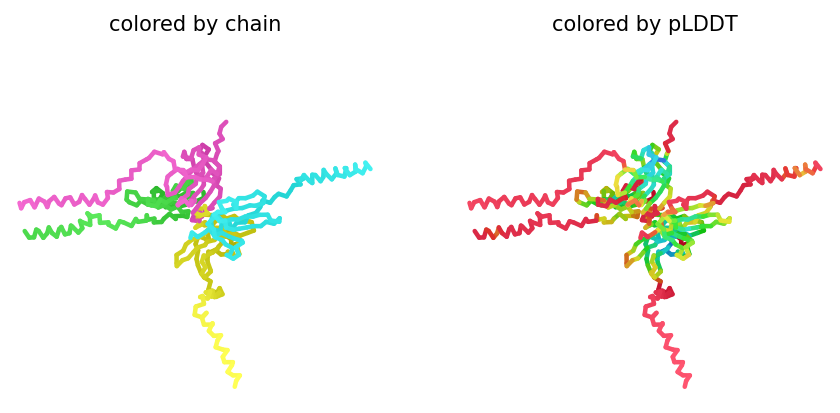

2024-11-13 23:36:15,839 alphafold2_multimer_v3_model_4_seed_006 recycle=0 pLDDT=59.3 pTM=0.298 ipTM=0.141
2024-11-13 23:36:29,179 alphafold2_multimer_v3_model_4_seed_006 recycle=1 pLDDT=60.2 pTM=0.299 ipTM=0.142 tol=6.51
2024-11-13 23:36:42,639 alphafold2_multimer_v3_model_4_seed_006 recycle=2 pLDDT=60.1 pTM=0.303 ipTM=0.143 tol=5.71
2024-11-13 23:36:56,020 alphafold2_multimer_v3_model_4_seed_006 recycle=3 pLDDT=59.7 pTM=0.307 ipTM=0.152 tol=2.99
2024-11-13 23:37:09,400 alphafold2_multimer_v3_model_4_seed_006 recycle=4 pLDDT=58.5 pTM=0.299 ipTM=0.141 tol=9.7
2024-11-13 23:37:22,778 alphafold2_multimer_v3_model_4_seed_006 recycle=5 pLDDT=60.5 pTM=0.309 ipTM=0.16 tol=2.86
2024-11-13 23:37:36,147 alphafold2_multimer_v3_model_4_seed_006 recycle=6 pLDDT=60.7 pTM=0.313 ipTM=0.149 tol=7.34
2024-11-13 23:37:49,604 alphafold2_multimer_v3_model_4_seed_006 recycle=7 pLDDT=60 pTM=0.303 ipTM=0.147 tol=2.38
2024-11-13 23:38:03,052 alphafold2_multimer_v3_model_4_seed_006 recycle=8 pLDDT=59.7 pTM=0.29

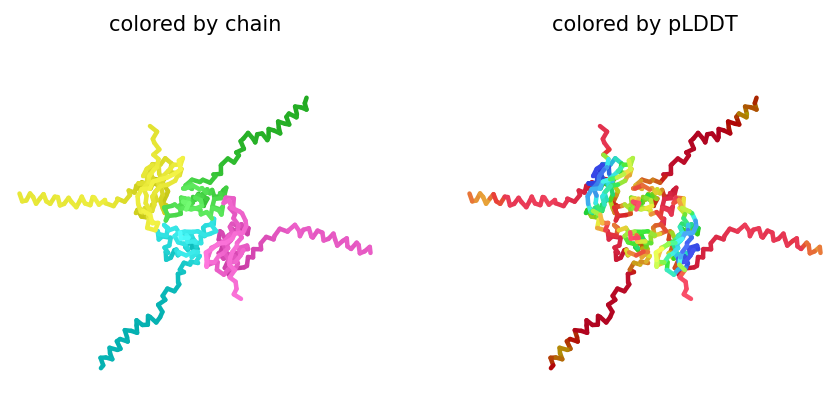

2024-11-13 23:40:57,724 alphafold2_multimer_v3_model_5_seed_006 recycle=0 pLDDT=58 pTM=0.299 ipTM=0.145
2024-11-13 23:41:11,082 alphafold2_multimer_v3_model_5_seed_006 recycle=1 pLDDT=56.6 pTM=0.28 ipTM=0.116 tol=4.62
2024-11-13 23:41:24,555 alphafold2_multimer_v3_model_5_seed_006 recycle=2 pLDDT=55.8 pTM=0.278 ipTM=0.116 tol=8.67
2024-11-13 23:41:38,055 alphafold2_multimer_v3_model_5_seed_006 recycle=3 pLDDT=56.2 pTM=0.273 ipTM=0.113 tol=7.82
2024-11-13 23:41:51,564 alphafold2_multimer_v3_model_5_seed_006 recycle=4 pLDDT=56 pTM=0.273 ipTM=0.109 tol=6.24
2024-11-13 23:42:05,046 alphafold2_multimer_v3_model_5_seed_006 recycle=5 pLDDT=53.7 pTM=0.282 ipTM=0.122 tol=11.2
2024-11-13 23:42:18,422 alphafold2_multimer_v3_model_5_seed_006 recycle=6 pLDDT=56.5 pTM=0.277 ipTM=0.113 tol=9.51
2024-11-13 23:42:31,789 alphafold2_multimer_v3_model_5_seed_006 recycle=7 pLDDT=57.2 pTM=0.279 ipTM=0.113 tol=6
2024-11-13 23:42:45,154 alphafold2_multimer_v3_model_5_seed_006 recycle=8 pLDDT=56.1 pTM=0.277 ip

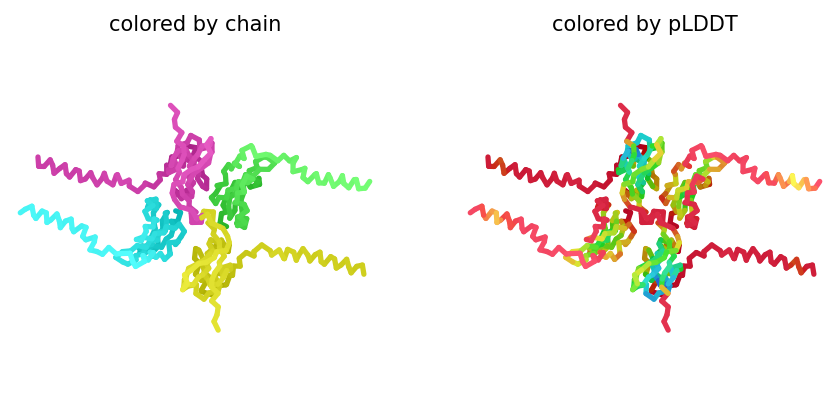

2024-11-13 23:45:39,627 alphafold2_multimer_v3_model_1_seed_007 recycle=0 pLDDT=56.7 pTM=0.299 ipTM=0.145
2024-11-13 23:45:52,998 alphafold2_multimer_v3_model_1_seed_007 recycle=1 pLDDT=57.8 pTM=0.289 ipTM=0.129 tol=4.57
2024-11-13 23:46:06,381 alphafold2_multimer_v3_model_1_seed_007 recycle=2 pLDDT=59.2 pTM=0.294 ipTM=0.137 tol=5.93
2024-11-13 23:46:19,820 alphafold2_multimer_v3_model_1_seed_007 recycle=3 pLDDT=59.7 pTM=0.302 ipTM=0.149 tol=1.7
2024-11-13 23:46:33,254 alphafold2_multimer_v3_model_1_seed_007 recycle=4 pLDDT=59.6 pTM=0.3 ipTM=0.142 tol=1.58
2024-11-13 23:46:46,683 alphafold2_multimer_v3_model_1_seed_007 recycle=5 pLDDT=59 pTM=0.297 ipTM=0.141 tol=2.13
2024-11-13 23:47:00,041 alphafold2_multimer_v3_model_1_seed_007 recycle=6 pLDDT=58.8 pTM=0.299 ipTM=0.143 tol=1.43
2024-11-13 23:47:13,410 alphafold2_multimer_v3_model_1_seed_007 recycle=7 pLDDT=58.8 pTM=0.29 ipTM=0.133 tol=3.46
2024-11-13 23:47:26,769 alphafold2_multimer_v3_model_1_seed_007 recycle=8 pLDDT=58 pTM=0.296 ip

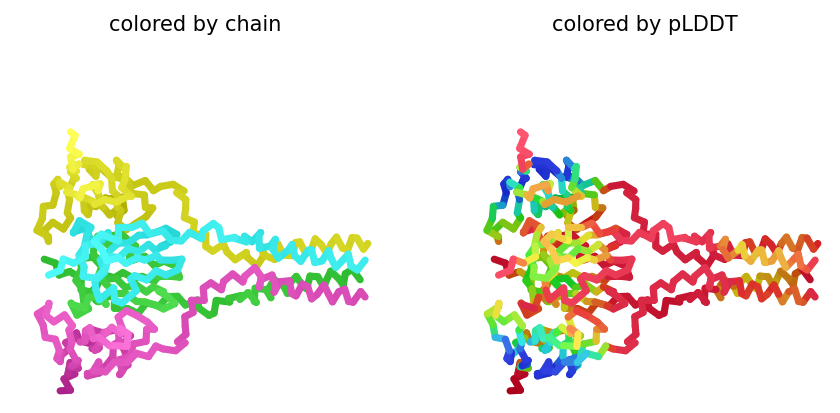

2024-11-13 23:50:21,577 alphafold2_multimer_v3_model_2_seed_007 recycle=0 pLDDT=59 pTM=0.295 ipTM=0.138
2024-11-13 23:50:35,000 alphafold2_multimer_v3_model_2_seed_007 recycle=1 pLDDT=67.6 pTM=0.432 ipTM=0.348 tol=13.7
2024-11-13 23:50:48,402 alphafold2_multimer_v3_model_2_seed_007 recycle=2 pLDDT=68.8 pTM=0.453 ipTM=0.367 tol=1.82
2024-11-13 23:51:01,711 alphafold2_multimer_v3_model_2_seed_007 recycle=3 pLDDT=67.1 pTM=0.396 ipTM=0.287 tol=0.957
2024-11-13 23:51:15,113 alphafold2_multimer_v3_model_2_seed_007 recycle=4 pLDDT=67 pTM=0.379 ipTM=0.274 tol=0.956
2024-11-13 23:51:28,421 alphafold2_multimer_v3_model_2_seed_007 recycle=5 pLDDT=67.4 pTM=0.393 ipTM=0.288 tol=0.545
2024-11-13 23:51:41,751 alphafold2_multimer_v3_model_2_seed_007 recycle=6 pLDDT=67.2 pTM=0.379 ipTM=0.266 tol=0.488
2024-11-13 23:51:41,753 alphafold2_multimer_v3_model_2_seed_007 took 93.6s (6 recycles)


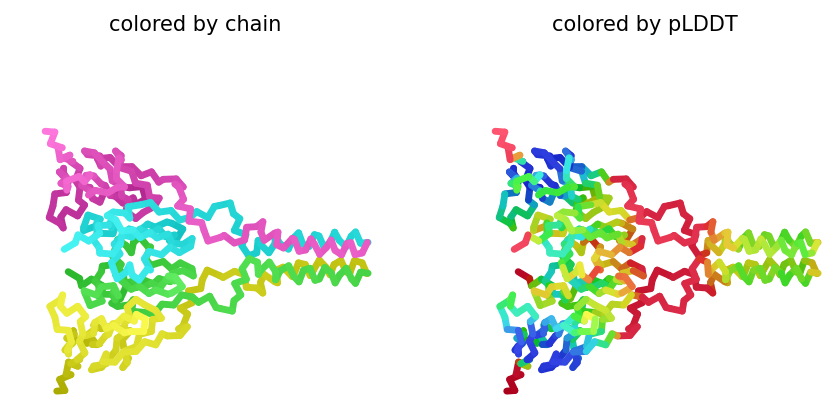

2024-11-13 23:51:55,657 alphafold2_multimer_v3_model_3_seed_007 recycle=0 pLDDT=59.8 pTM=0.337 ipTM=0.208
2024-11-13 23:52:09,016 alphafold2_multimer_v3_model_3_seed_007 recycle=1 pLDDT=58.9 pTM=0.284 ipTM=0.125 tol=5.19
2024-11-13 23:52:22,386 alphafold2_multimer_v3_model_3_seed_007 recycle=2 pLDDT=58.7 pTM=0.281 ipTM=0.122 tol=6.8
2024-11-13 23:52:35,765 alphafold2_multimer_v3_model_3_seed_007 recycle=3 pLDDT=58.3 pTM=0.272 ipTM=0.106 tol=4.99
2024-11-13 23:52:49,164 alphafold2_multimer_v3_model_3_seed_007 recycle=4 pLDDT=58.7 pTM=0.266 ipTM=0.105 tol=10.2
2024-11-13 23:53:02,570 alphafold2_multimer_v3_model_3_seed_007 recycle=5 pLDDT=58.2 pTM=0.268 ipTM=0.104 tol=6.6
2024-11-13 23:53:15,955 alphafold2_multimer_v3_model_3_seed_007 recycle=6 pLDDT=58.1 pTM=0.271 ipTM=0.106 tol=9.25
2024-11-13 23:53:29,343 alphafold2_multimer_v3_model_3_seed_007 recycle=7 pLDDT=57.6 pTM=0.267 ipTM=0.102 tol=6.25
2024-11-13 23:53:42,744 alphafold2_multimer_v3_model_3_seed_007 recycle=8 pLDDT=58.3 pTM=0.

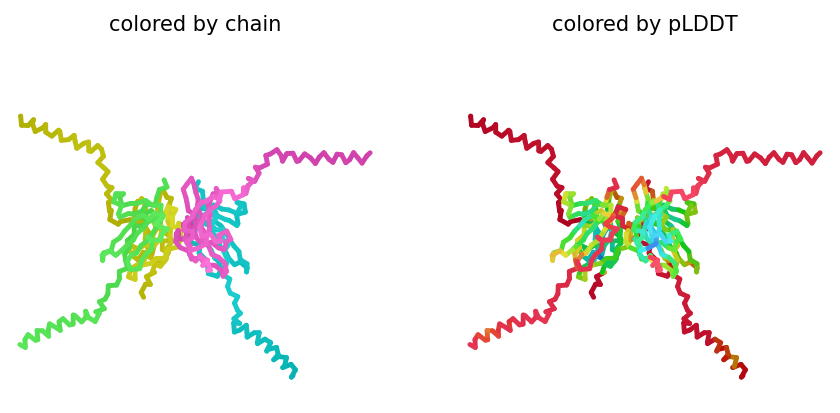

2024-11-13 23:56:37,942 alphafold2_multimer_v3_model_4_seed_007 recycle=0 pLDDT=59.3 pTM=0.284 ipTM=0.129
2024-11-13 23:56:51,353 alphafold2_multimer_v3_model_4_seed_007 recycle=1 pLDDT=58.6 pTM=0.3 ipTM=0.144 tol=9.23
2024-11-13 23:57:04,746 alphafold2_multimer_v3_model_4_seed_007 recycle=2 pLDDT=60.4 pTM=0.314 ipTM=0.164 tol=10.4
2024-11-13 23:57:18,115 alphafold2_multimer_v3_model_4_seed_007 recycle=3 pLDDT=59.9 pTM=0.303 ipTM=0.15 tol=3.02
2024-11-13 23:57:31,490 alphafold2_multimer_v3_model_4_seed_007 recycle=4 pLDDT=61.2 pTM=0.301 ipTM=0.138 tol=9.36
2024-11-13 23:57:44,851 alphafold2_multimer_v3_model_4_seed_007 recycle=5 pLDDT=59.9 pTM=0.302 ipTM=0.144 tol=2.76
2024-11-13 23:57:58,234 alphafold2_multimer_v3_model_4_seed_007 recycle=6 pLDDT=59.2 pTM=0.298 ipTM=0.143 tol=4.24
2024-11-13 23:58:11,619 alphafold2_multimer_v3_model_4_seed_007 recycle=7 pLDDT=59.8 pTM=0.306 ipTM=0.152 tol=3.49
2024-11-13 23:58:25,011 alphafold2_multimer_v3_model_4_seed_007 recycle=8 pLDDT=60.4 pTM=0.3

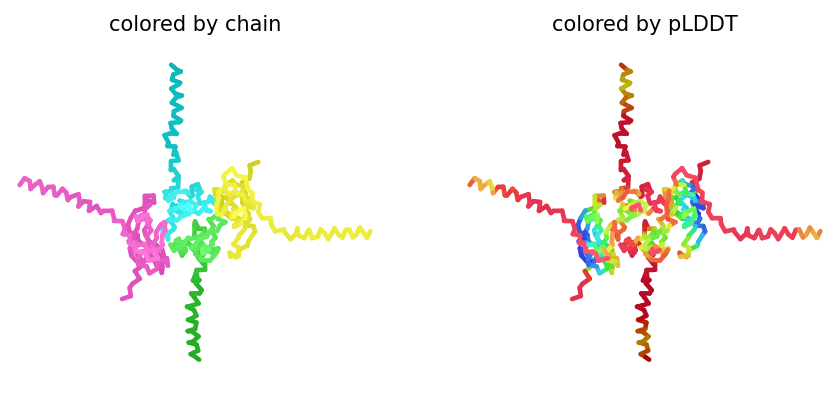

2024-11-14 00:01:19,965 alphafold2_multimer_v3_model_5_seed_007 recycle=0 pLDDT=56.8 pTM=0.288 ipTM=0.132
2024-11-14 00:01:33,369 alphafold2_multimer_v3_model_5_seed_007 recycle=1 pLDDT=57.4 pTM=0.279 ipTM=0.116 tol=6.05
2024-11-14 00:01:46,802 alphafold2_multimer_v3_model_5_seed_007 recycle=2 pLDDT=56.1 pTM=0.273 ipTM=0.109 tol=7.47
2024-11-14 00:02:00,225 alphafold2_multimer_v3_model_5_seed_007 recycle=3 pLDDT=55.9 pTM=0.279 ipTM=0.116 tol=5.34
2024-11-14 00:02:13,624 alphafold2_multimer_v3_model_5_seed_007 recycle=4 pLDDT=57.1 pTM=0.274 ipTM=0.109 tol=5.76
2024-11-14 00:02:27,016 alphafold2_multimer_v3_model_5_seed_007 recycle=5 pLDDT=56.2 pTM=0.277 ipTM=0.114 tol=6.88
2024-11-14 00:02:40,412 alphafold2_multimer_v3_model_5_seed_007 recycle=6 pLDDT=55.9 pTM=0.277 ipTM=0.115 tol=5.73
2024-11-14 00:02:53,800 alphafold2_multimer_v3_model_5_seed_007 recycle=7 pLDDT=56.2 pTM=0.281 ipTM=0.12 tol=4.25
2024-11-14 00:03:07,179 alphafold2_multimer_v3_model_5_seed_007 recycle=8 pLDDT=56 pTM=0.2

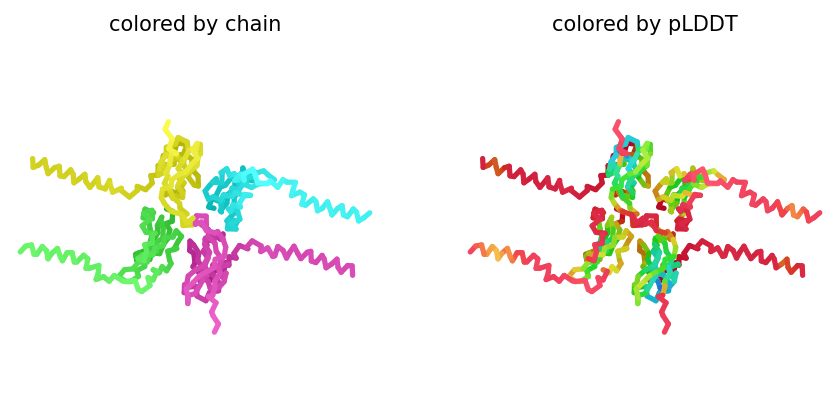

2024-11-14 00:05:48,571 reranking models by 'multimer' metric
2024-11-14 00:05:50,093 Warning: importing 'simtk.openmm' is deprecated.  Import 'openmm' instead.
2024-11-14 00:08:38,468 Relaxation took 169.9s
2024-11-14 00:08:38,469 rank_001_alphafold2_multimer_v3_model_2_seed_005 pLDDT=69.9 pTM=0.422 ipTM=0.326
2024-11-14 00:08:38,469 rank_002_alphafold2_multimer_v3_model_2_seed_000 pLDDT=69.6 pTM=0.421 ipTM=0.314
2024-11-14 00:08:38,470 rank_003_alphafold2_multimer_v3_model_2_seed_002 pLDDT=69 pTM=0.402 ipTM=0.296
2024-11-14 00:08:38,470 rank_004_alphafold2_multimer_v3_model_2_seed_004 pLDDT=69.2 pTM=0.396 ipTM=0.297
2024-11-14 00:08:38,471 rank_005_alphafold2_multimer_v3_model_2_seed_001 pLDDT=68.4 pTM=0.397 ipTM=0.292
2024-11-14 00:08:38,471 rank_006_alphafold2_multimer_v3_model_4_seed_005 pLDDT=69.1 pTM=0.386 ipTM=0.28
2024-11-14 00:08:38,472 rank_007_alphafold2_multimer_v3_model_2_seed_007 pLDDT=67.2 pTM=0.379 ipTM=0.266
2024-11-14 00:08:38,472 rank_008_alphafold2_multimer_v3_mode

0

In [5]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

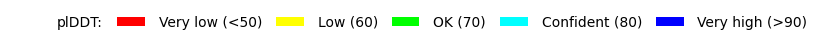

In [6]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()


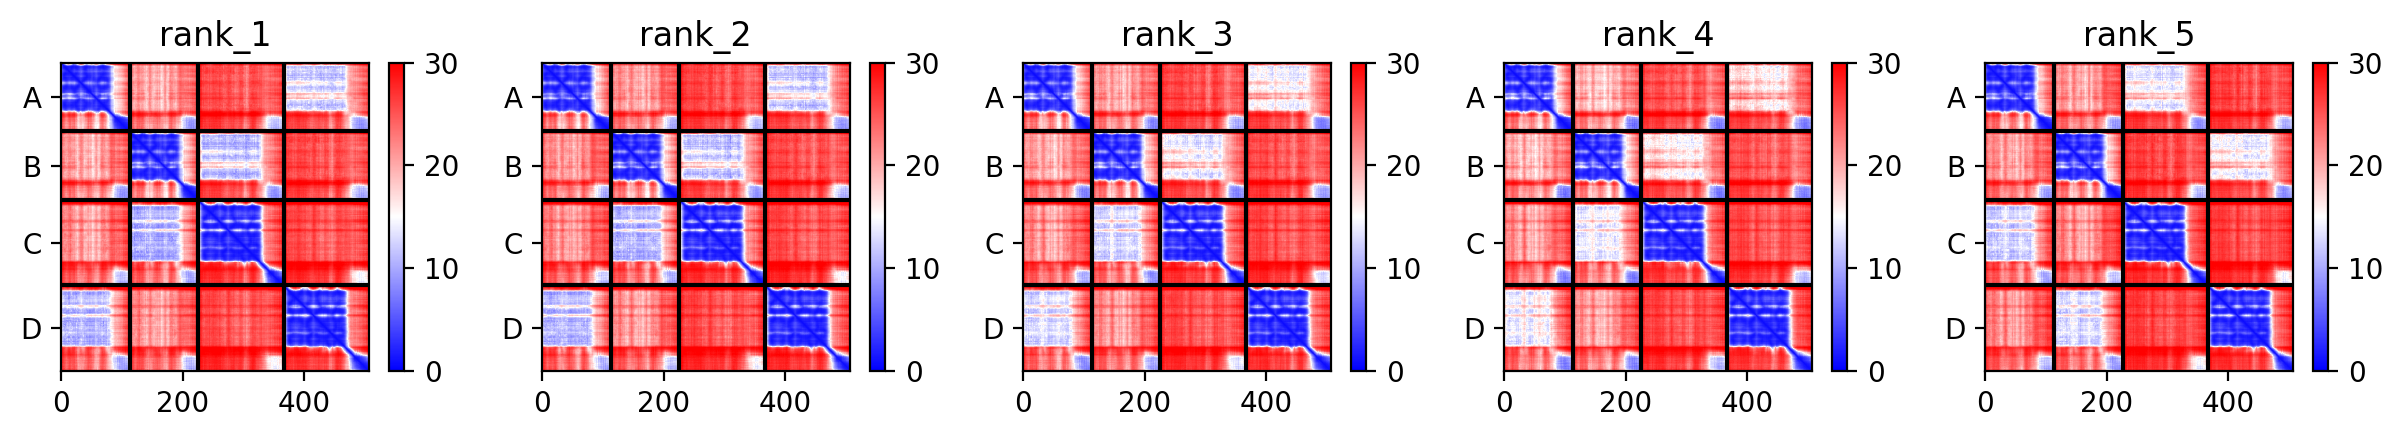
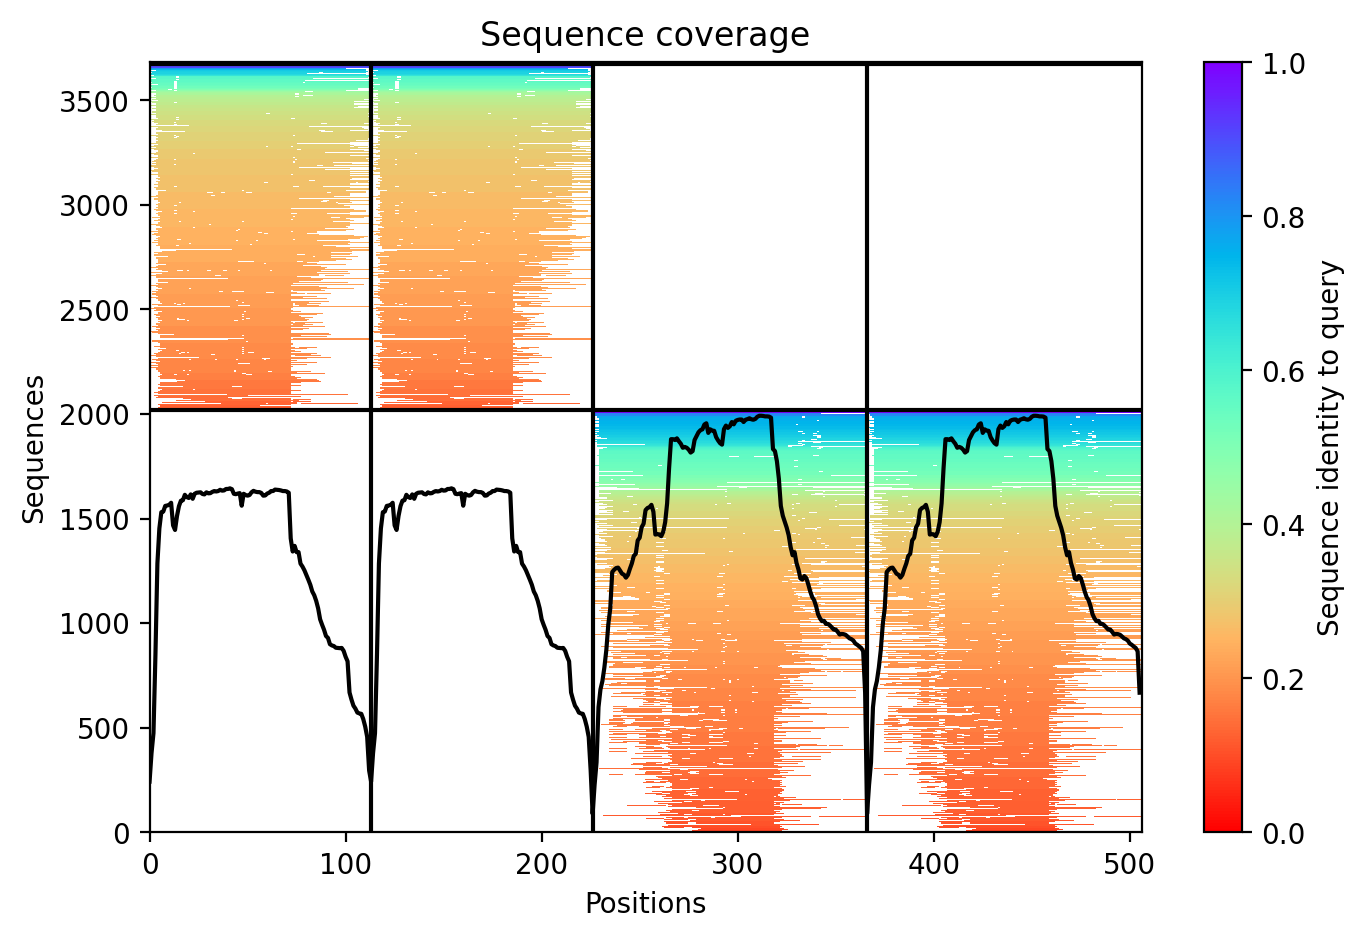
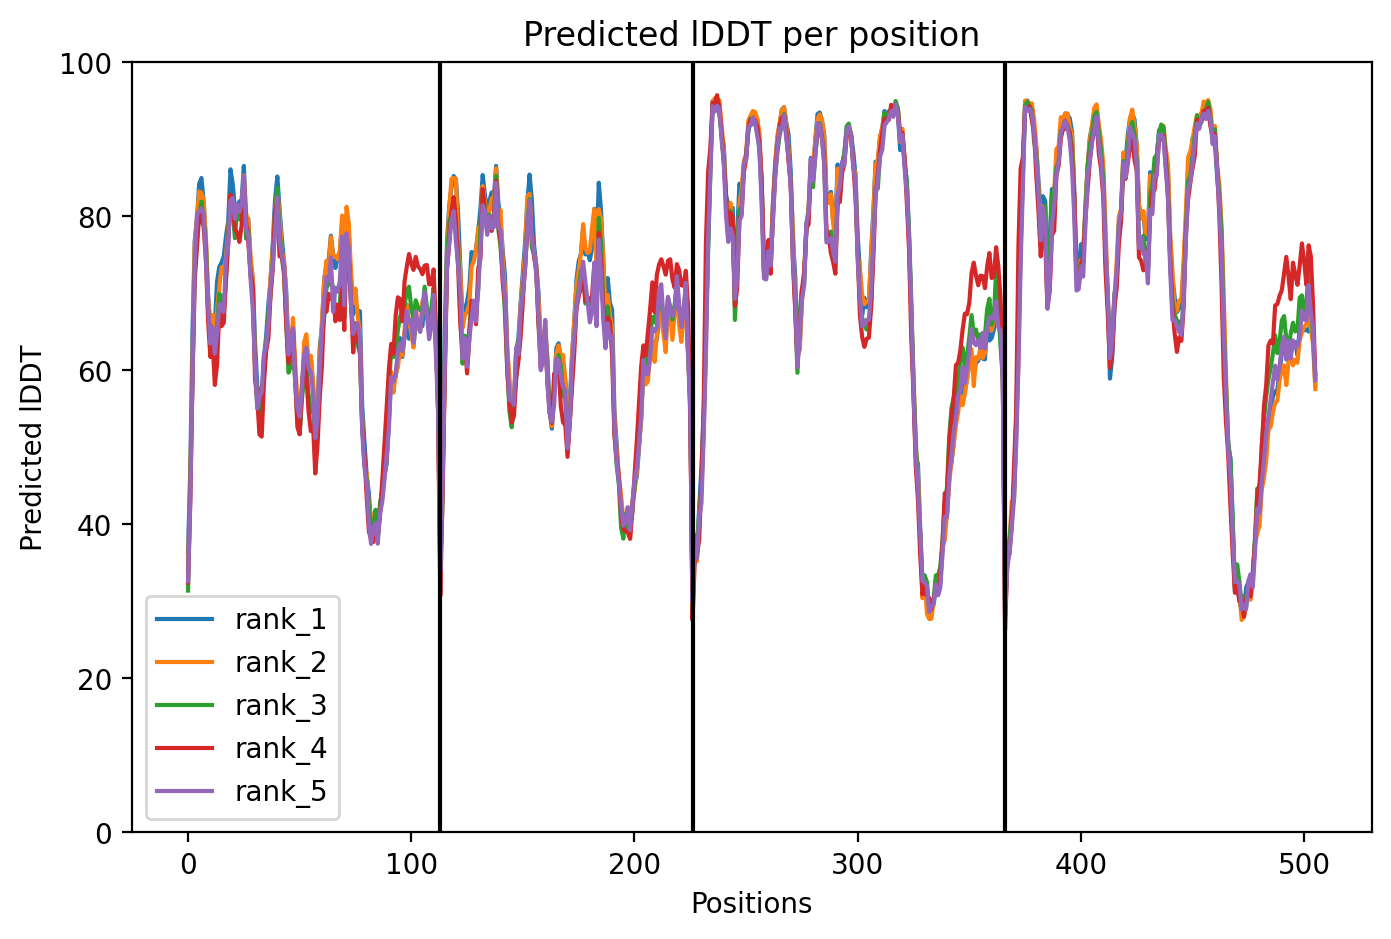

In [7]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

In [8]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Uploaded tetramer_w_ECD_and_TM_Apo_84146.result.zip to Google Drive with ID 16DzHJGaPdEHX1PJ2JVigFLvrckw5cQ3r


# Instructions <a name="Instructions"></a>
For detailed instructions, tips and tricks, see recently published paper at [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5)

**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomic identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomic identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

It is also possilbe to proide custom MSAs for complex predictions. Read more about the format [here](https://github.com/sokrypton/ColabFold/issues/76).

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**PDB100** <a name="pdb100"></a>

As of 23/06/08, we have transitioned from using the PDB70 to a 100% clustered PDB, the PDB100. The construction methodology of PDB100 differs from that of PDB70.

The PDB70 was constructed by running each PDB70 representative sequence through [HHblits](https://github.com/soedinglab/hh-suite) against the [Uniclust30](https://uniclust.mmseqs.com/). On the other hand, the PDB100 is built by searching each PDB100 representative structure with [Foldseek](https://github.com/steineggerlab/foldseek) against the [AlphaFold Database](https://alphafold.ebi.ac.uk).

To maintain compatibility with older Notebook versions and local installations, the generated files and API responses will continue to be named "PDB70", even though we're now using the PDB100.

**Using custom templates** <a name="custom_templates"></a>

To predict the structure with a custom template (PDB or mmCIF formatted): (1) change the `template_mode` to "custom" in the execute cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible).

* Templates must follow the four letter PDB naming with lower case letters.

* Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.

* Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.

If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparison to the full AlphaFold2 and AlphaFold2 Colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [paper](https://www.nature.com/articles/s41592-022-01488-1).

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
